# IMF: Implicit Matrix Factorizationの更新式の導出
$n$回のセッションについて，$m$個の商品の評価が$R$という$n \times m$行列で与えられているものとする．
ここで，$R$の要素$r_{s, i}$について，

> セッション$s$において商品$i$が購入された場合，$r_{s, i} =  r_{\rm purchase}$ \
> セッション$s$において商品$i$が購入されなかった場合，$r_{s, i}$をセッション$s$における商品$i$の閲覧回数

として定義する．

セッション$s$における商品$i$の行為を表す2値変数$\bar{r}_{s, i}$を
$$
\bar{r}_{s, i} = \begin{cases}
    1 & (r_{s, i} > 0) \\
    0 & (r_{s, i} = 0)
  \end{cases}
$$

とし，その評価に対する信頼度を
$$
c_{s, i} = 1 + \alpha r_{s, i}
$$
として表現する．

いま
$$
R = P^t Q
$$
となるように$R$を分解したい．ただし$P^t$は$n \times k$行列，$Q$は$k \times m$行列であり($k$は任意の整数)，それぞれ利用者と商品を特徴づける．
ここで，以下の損失関数を最小化するという問題を考える：
$$
L = \dfrac{1}{2} \sum_{(s, i) \in D} c_{s, i} (\bar{r}_{s, i} - {\bf p}_s^t {\bf q}_i)^2 + \dfrac{\lambda_p}{2} \sum_s {\bf p}_s^2 + \dfrac{\lambda_q}{2} \sum_i {\bf q_i}^2
$$
ここで$D$はセッション$s$と商品$i$のビューをペアでまとめた集合であり，${\bf p}_s^t$は$P^t$の$s$行目，${\bf q}_i$は$Q$の$i$列目をベクトルで表したものである．
さらに，正則化のパラメータとして$\lambda_p, \lambda_q$を導入した．
これを${\bf p}$と${\bf q}$によって微分することで，
$$
{\bf p}_s \leftarrow (1 - \alpha \lambda_p) {\bf p}_s +  \alpha \sum_{i \in D(s)} (r_{s, i} - {\bf p}_s^t {\bf q}_i) {\bf q}_i \\
{\bf q}_i \leftarrow (1 - \alpha \lambda_q) {\bf q}_s +  \alpha \sum_{s \in D(i)} (r_{s, i} - {\bf p}_s^t {\bf q}_i) {\bf p}_s 
$$
が更新式となる．ただし$\alpha$は更新の速度を与えるパラメータであり，$D(s)$はセッション$s$に含まれるような商品の集合，$D(i)$は商品$i$をビューに含むようなセッションの集合である．


## 更新式の修正
商品の行列$Q$を固定したうえで損失関数$L$を最小化するように，セッションの行列$P$を定めると
$$
{\bf p}_s = \left( \lambda_p 1_k +  \sum_{i \in D(s)} c_{s, i} {\bf q}_i {\bf q}_i^t \right)^{-1} \sum_{i \in D(s)}  c_{s, i} {\bf q}_i
$$
のように計算される．
ここで，セッション$s$に含まれる商品$i$の列について，商品の行列$Q$から取り出したものを$Q_s$とし，$c_{s, i}$からベクトルとして並べたものを${\bf c}_s$，対角成分に並べた行列を$C_s$とすれば，
$$
{\bf p}_s = \left( \lambda_p 1_k + Q_s C_s Q_s^t \right)^{-1} Q_s {\bf c}_s
$$
と表現することができる．
逆にセッションの行列$P$を固定した場合，商品の行列$Q$は
$$
{\bf q}_i = ( \lambda_q 1_k + P_i C_i P_i^t )^{-1} P_i {\bf c}_i
$$
として計算できる．ただし，商品$i$を含むようなセッション$s$について，セッションの行列$P$から取り出したものを$P_i$とし，$c_{s,, i}$からベクトルとして並べたものを${\bf c}_i$，対角成分に並べた行列を$C_i$としている．
ここで， $\left( \lambda_p + Q_s Q_s^t \right)^{-1}$の計算には$k \times k$行列の逆行列が必要になることに注意する．Woodburyの逆行列公式
$$
(A + BCD)^{-1} = A^{-1} - A^{-1} B (C^{1} + DA^{-1} B)^{-1} D A^{-1}
$$
を用いることで，
$$
{\bf p}_s = \lambda_p^{-1} Q_s (1_n - (C_s^{-1} \lambda_p + Q_s^t Q_s)^{-1} Q_s^t Q_s) {\bf c}_s
$$

のように変形できる．
セッション$s$の長さを$l_s$とすると，$(\lambda_p + Q^t Q)^{-1}$は$l_s \times l_s$行列の逆行列として求められる．
多くの$s$において$l_s < k$であるため，${\bf p}_s$の計算を高速化することができる．
一方${\bf q}_i$の計算においては，商品$i$を含むようなセッション$s$の数$l_i$はしばしば$k$よりも非常に大きくなるため，Woodburyの逆行列公式を用いた修正は行わない．

なお，各ステップにおいて${\bf p}_s$や${\bf q}_i$について$2$次形式の最小化をしているため，損失関数が逓減する方向に更新されるはず．ただし，最適値への収束は保証されない(はず)．

# セットアップ

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm # for文の進捗状況を見るために使う
import seaborn as sns

In [25]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

# データの読み込み
開くとそれぞれのデータがどのような形か確認できるようになっている

購入データ`df_train_purchases`

In [26]:
path_data = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data'
df_train_purchases = pd.read_csv(path_data + r"\train_purchases.csv")
display(df_train_purchases)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


セッションのデータ`df_train_sessions`

In [27]:
df_train_sessions = pd.read_csv(path_data + r"\train_sessions.csv")
display(df_train_sessions)

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


商品の候補一覧`df_candidate_items`

In [28]:
df_candidate_items = pd.read_csv(path_data + r"\candidate_items.csv")
display(df_candidate_items)

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


特徴量データ`df_item_features`

In [29]:
df_item_features = pd.read_csv(path_data + r"\item_features.csv")
display(df_item_features)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


テストデータ`df_test_leaderboard`

In [30]:
df_test_leaderboard = pd.read_csv(path_data + r"\test_leaderboard_sessions.csv")
display(df_test_leaderboard)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# データセットの分割
`X`はセッション，`y`は購入，`R`は`X`と`y`をまとめたもの．
これらを`train`と`valid`に分ける．

In [31]:
# ランダムに抽出
session_list = df_train_purchases["session_id"].unique()
train_ratio = 0.99
train_size = int(len(session_list) * train_ratio)
np.random.shuffle(session_list)
session_list_train = session_list[0: train_size]
session_list_valid = session_list[train_size: ]

def split_data(df_train_sessions, df_train_purchases, session_list_sample):
    df_train_sessions_sample = df_train_sessions[df_train_sessions["session_id"].isin(session_list_sample)].copy()
    df_train_purchases_sample = df_train_purchases[df_train_purchases["session_id"].isin(session_list_sample)].copy()
    
    # Xの処理
    df_R_X = df_train_sessions_sample.copy()
    df_eval = df_R_X.groupby(["session_id", "item_id"]).count().rename(columns = {"date": "eval"})
    df_R_X = df_train_sessions_sample.drop_duplicates(subset = ["session_id", "item_id"])
    df_R_X = pd.merge(df_R_X, df_eval, how = "left", on = ["session_id", "item_id"])
    df_R_X["flag"] = "view" # あとでパラメータの変更に必要
    
    # yの処理
    df_R_y = df_train_purchases_sample.copy()
    df_R_y["eval"] = 1.0 # 適当に仮置きする
    df_R_y["flag"] = "purchase"
    
    df_R = pd.concat([df_R_X, df_R_y], axis = 0) # 縦に結合
    df_R.index = df_R["session_id"].astype("str") + "-" + df_R["item_id"].astype("str") # 複合キーを作成(少し時間がかかる)
    return df_train_sessions_sample, df_train_purchases_sample, df_R

# 訓練データ
df_X_train, df_y_train, df_R_train = split_data(df_train_sessions, df_train_purchases, session_list_train)
df_X_valid, df_y_valid, df_R_valid = split_data(df_train_sessions, df_train_purchases, session_list_valid)
df_R_train

,session_id,item_id,date,eval,flag
3-9655,3,9655,2020-12-18 21:25:00.373,2.0,view
13-15654,13,15654,2020-03-13 19:35:27.136,1.0,view
18-18316,18,18316,2020-08-26 19:18:30.833,1.0,view
18-2507,18,2507,2020-08-26 19:16:31.211,1.0,view
18-4026,18,4026,2020-08-26 19:15:47.232,1.0,view
...,...,...,...,...,...
4439986-2915,4439986,2915,2021-05-13 11:56:37.464,1.0,purchase
4439990-8786,4439990,8786,2020-08-22 14:28:22.382,1.0,purchase
4439994-21630,4439994,21630,2020-11-27 20:10:28.961,1.0,purchase
4439999-16962,4439999,16962,2020-11-27 11:01:41.356,1.0,purchase


# 実装のための関数・クラスを作成

## 進捗状況を表示するためのクラス

In [32]:
class progress_manager:
    def __init__(self, total_iteration, idx_step = 100000):
        self.time_start = datetime.datetime.now()
        self.total_iteration = total_iteration
        self.idx_step = idx_step
    
    def show_progress(self, idx):
        if idx % self.idx_step == 1:
            time_now = datetime.datetime.now()
            time_end_expected = self.time_start + (time_now - self.time_start) * (self.total_iteration / (idx+1))
            print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                          ",  進捗：", idx+1, "/", self.total_iteration, "({:.2%})".format(idx/self.total_iteration), end = "\r")
        if idx == self.total_iteration - 1:
            time_now = datetime.datetime.now()
            print("経過時間(実績)　=", time_now - self.time_start, "\n")

# test
total_iteration = 100000 * 50
manager = progress_manager(total_iteration, idx_step = total_iteration * 0.1)
for i in range(total_iteration):
    manager.show_progress(i)

経過時間(実績)　= 0:00:01.623157 4500002 / 5000000 (90.00%)



## MRRを計算するための関数

In [33]:
# df_targetは正解ラベル，列には["session_id", "item_id"]が必要．
# df_predはsubmitと同様の順位表，列には["session_id", "item", "rank"]が必要．
def mean_reciprocal_rank(df_target, df_pred):
    df_MRR = pd.merge(df_target,df_pred, how = "left", on = ["session_id", "item_id"]) # 各セッションごとに，購入された商品の順位を記録
    df_MRR["reciprocal_rank"] = 1.0 / df_MRR["rank"] # reciprocal rankを計算
    df_MRR["reciprocal_rank"].fillna(0.0, inplace = True) # 順位がない場合はreciprocal rankは0になる
    return df_MRR["reciprocal_rank"].mean() # 平均値がMRRになる

## 確率的行列分解を実装

In [42]:
# 行列分解するクラス
# df_Rはsession_id, item, evaluationを縦持ちで保存しているデータフレーム
# df_item_featuresは商品の特徴量をまとめている，セッションに出てこない商品も含めるためだけに使う
# k_dimは取り出したい特徴量の次元

class matrix_factorization:
    def __init__(self, df_R, df_item_features, k_dim, alpha = 1.0, r_purchase = 1.0, lambda_p = 0.1, lambda_q = 0.1):
        # いろいろ代入
        # self.df_R = df_R.drop_duplicates(subset = ["session_id", "item_id"]) # 重複があると嫌なので削除
        self.df_R = df_R.copy()
        self.r_purchase = r_purchase
        self.df_R["eval"].where(self.df_R["flag"] == "purchase", self.r_purchase, inplace = True)
        # self.df_R["eval"] =  * (df_R["flag"] == "view") + r_purchase * (df_R["flag"] != "view")
        self.k_dim = k_dim
        self.alpha = alpha
        self.lambda_p = lambda_p
        self.lambda_q = lambda_q
        self.session_id_list = df_R["session_id"].unique()
        self.item_id_list = df_item_features["item_id"].unique()
        self.loss_prev = np.inf # 任意の実数より大きい
        
        # パラメーター
        self.feature_name_list = ["feature{}".format(x + 1) for x in range(k_dim)]
        num_session = len(self.session_id_list)
        num_item = len(self.item_id_list)
        
        # PとQを表すデータフレーム
        self.df_P = pd.DataFrame(np.random.randn(k_dim, num_session), columns = self.session_id_list, index = self.feature_name_list)
        self.df_Q = pd.DataFrame(np.random.randn(k_dim, num_item), columns = self.item_id_list, index = self.feature_name_list)
        
        print("sessionとitemの変換辞書作成開始")
        # sessionとitemをnpのインデックスで変換するような辞書を作成
        df_session_to_np = pd.DataFrame(columns = ["session_id", "session_id_np"])
        df_session_to_np["session_id"] = self.session_id_list
        df_session_to_np["session_id_np"] = np.arange(len(self.session_id_list))

        df_item_to_np = pd.DataFrame(columns = ["item_id", "item_id_np"])
        df_item_to_np["item_id"] = self.item_id_list
        df_item_to_np["item_id_np"] = np.arange(len(self.item_id_list))
        
        self.df_R = pd.merge(self.df_R, df_session_to_np, how = "left", on = "session_id")
        self.df_R = pd.merge(self.df_R, df_item_to_np, how = "left", on = "item_id")
        
        # 評価についてもnpのインデックスから参照できるような辞書を作成
        self.dict_eval_from_np = self.df_R.groupby(["session_id_np", "item_id_np"]).eval.sum().to_dict() # sumは適当，maxでも集計関数ならなんでもok
        
        # sessionからitemのリストを取り出す辞書
        self.dict_session_np_to_item_np = self.df_R.groupby('session_id_np').item_id_np.apply(lambda x: x.to_list()).to_dict()
        print("処理1完了：session -> item")
        # sessionからitemのリストを取り出す辞書
        self.dict_item_np_to_session_np = self.df_R.groupby('item_id_np').session_id_np.apply(lambda x: x.to_list()).to_dict()
        print("処理2完了：item -> session")
        # sessionからevalのリストを取り出す辞書
        self.dict_session_np_to_eval = self.df_R.groupby("session_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理3完了：session -> eval")
        # itemからevalのリストを取り出す辞書
        self.dict_item_np_to_eval = self.df_R.groupby("item_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理4完了：item -> eval")
        
        # idからnumpy行列のインデックスに変換するための辞書
        self.dict_session_to_idx = dict( zip(self.df_P.columns, range(len(self.df_P.columns))) )
        self.dict_item_to_idx = dict( zip(self.df_Q.columns, range(len(self.df_Q.columns))) )
    
    def reset_params(self, alpha = 1.0, r_purchase = 1.0, lambda_p = 0.1, lambda_q = 0.1):
        self.alpha = alpha
        self.lambda_p = lambda_p
        self.lambda_q = lambda_q
        self.loss_prev = np.inf
        self.r_purchase = r_purchase
        self.df_R["eval"].where(self.df_R["flag"] == "purchase", self.r_purchase, inplace = True)
        #self.df_R["eval"] = 1.0 * (self.df_R["flag"] == "view") + r_purchase * (self.df_R["flag"] != "view")
        print("処理開始：eval関係")
        # 評価についてもnpのインデックスから参照できるような辞書を作成
        self.dict_eval_from_np = self.df_R.groupby(["session_id_np", "item_id_np"]).eval.sum().to_dict() # sumは適当，maxでも集計関数ならなんでもok
        print("処理0完了：np -> eval")
        self.dict_session_np_to_eval = self.df_R.groupby("session_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理1完了：session -> eval")
        # itemからevalのリストを取り出す辞書
        self.dict_item_np_to_eval = self.df_R.groupby("item_id_np").eval.apply(lambda x: x.to_list()).to_dict()
        print("処理2完了：item -> eval")
    
    def calc_loss(self):
        # データフレームだと遅すぎるのでnumpyベースで計算
        P = self.df_P.values
        Q = self.df_Q.values
        
        # 損失関数の計算(Frobenius norm)
        loss = 0.5 * (self.lambda_p * np.linalg.norm(P, "fro") ** 2.0 + self.lambda_q * np.linalg.norm(Q, "fro") ** 2.0)
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(self.df_R["session_id"]), idx_step = 100000)
        
        # 評価がなされているペアに対しての処理
        # s：セッションid，i：商品id，r_s_i：セッションiにおける商品iの評価
        for idx, (s, i, r_s_i) in enumerate(zip(self.df_R["session_id"], self.df_R["item_id"], self.df_R["eval"])): # 高速化するため列で取り出す
            # セッションと商品に対応するベクトルを抽出
            s_idx = self.dict_session_to_idx[s]
            i_idx = self.dict_item_to_idx[i]
            p_vec_s = P[:, s_idx]
            q_vec_i = Q[:, i_idx]

            # 損失関数の計算
            loss += (1.0 + self.alpha * r_s_i) * (1.0 - p_vec_s.dot(q_vec_i)) ** 2.0
            manager.show_progress(idx) # 進捗状況の表示

        # print("loss = ", loss, "\n")
        return loss
           
    def update_P(self):
        P = self.df_P.values
        Q = self.df_Q.values
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(self.dict_session_np_to_item_np), idx_step = 10000)
        
        for idx, (session_np, item_id_np_list) in enumerate(self.dict_session_np_to_item_np.items()): # セッションsに関わる商品のリストに注目
            eval_vec = np.array(self.dict_session_np_to_eval[session_np])
            c_s_vec = 1.0 + self.alpha * eval_vec
            C_s_inv = np.diag(1.0 / c_s_vec)
            n_item = len(item_id_np_list)
            Q_s = Q[:, item_id_np_list] # セッションsに含まれる商品のベクトルをまとめたもの
            
            QQ_s = Q_s.T.dot(Q_s) # 数式を見やすくするため
            QQ_s_inv = np.linalg.inv(self.lambda_p * C_s_inv + QQ_s) # QQ_sを正則化しつつ逆行列を計算したもの
            
            # Woodburyの逆行列公式を用いたアルゴリズムで高速化
            P[:, session_np] = (1.0 / self.lambda_p) * Q_s.dot(np.eye(n_item) - QQ_s_inv.dot(QQ_s)).dot(c_s_vec)
            manager.show_progress(idx) # 進捗状況の表示
            
        self.df_P = pd.DataFrame(P, index = self.df_P.index, columns = self.df_P.columns)
        
    def update_Q(self):
        P = self.df_P.values
        Q = self.df_Q.values
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(self.dict_item_np_to_session_np), idx_step = 1000)
        
        for idx, (item_id_np, session_np_list) in enumerate(self.dict_item_np_to_session_np.items()):
            eval_vec = np.array(self.dict_item_np_to_eval[item_id_np])
            c_i_vec = 1.0 + self.alpha * eval_vec
            C_i = np.diag(c_i_vec)
            P_i = P[:, session_np_list]
            Q[:, item_id_np] = np.linalg.inv(self.lambda_q*np.eye(self.k_dim) + P_i.dot(C_i).dot(P_i.T)).dot(P_i).dot(c_i_vec)
            
            manager.show_progress(idx) # 進捗状況の表示
            
        self.df_Q = pd.DataFrame(Q, index = self.df_Q.index, columns = self.df_Q.columns)
        
    def inverse_matrix_by_Woodbury(self, X, lambda_x):
        n_x_row = X.shape[0]
        n_x_col = X.shape[1]
        return (1.0/lambda_x) * (np.eye(n_x_row) - X.dot(np.linalg.inv(np.eye(n_x_col)*lambda_x + X.T.dot(X)).dot(X.T)))
    
    def update(self, num_iteration, threshold_break = 0.01):
        # self.loss_list = [[] for _ in range(num_iteration)] # 損失関数をプロットするためのレコード
        self.loss_list = []
        
        for t in range(num_iteration):
            print("======= t = ", t, "=========")
            print("update P")
            self.update_P()
            print("update Q")
            self.update_Q()
            print("calculate loss")
            loss_t = self.calc_loss()
            
            self.loss_list.append(loss_t)
            print(self.loss_t)
            # lossが収束した場合は終了
            if (1.0 - loss_t / self.loss_prev < threshold_break) & (loss_t < self.loss_prev):
                break
            else:
                self.loss_prev = loss_t
        return self.loss_list
    
    # セッションsのビューに含まれる商品の一覧item_id_listに基づいて商品ベクトルの重心を計算し，
    # 候補となる商品の中から近い商品ベクトルを持つものを探す
    def search_nearest_neighborhood(self, item_id_list, df_candidate_items_on_Q):
        # 商品ベクトルQ上の重心によるモデル
        weight = np.arange(1, len(item_id_list)+1, 1) # 直近のデータをより大きく重みづけ
        weight = weight / sum(weight)
        q_vec_s = self.df_Q.T.loc[item_id_list].T.dot(weight).values # セッションsのビューに含まれる商品の重心を計算(よく考えるとわかる)
        
        df_distance = (df_candidate_items_on_Q - q_vec_s) * (df_candidate_items_on_Q - q_vec_s)
        df_distance = df_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
        index_to_drop = df_distance.index.isin(item_id_list) # ビューに含まれる商品は解答にならないはず
        df_distance = df_distance[~index_to_drop]
        return df_distance.index.values
    
    def predict_items(self, df_test_leaderboard, df_candidate_items, num_prediction = 100):
        session_id_list = df_test_leaderboard["session_id"].unique() # テストデータに含まれるセッションの一覧
        
        # predictionのための空のデータフレームを用意
        df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction))
        df_pred["session_id"] = np.repeat(session_id_list, num_prediction, axis = 0) # session_idは先に埋める
        df_pred["rank"] = np.tile(range(1, num_prediction+1), len(session_id_list)) # rankも埋める
        item_id_values = np.zeros(len(df_pred)) # pandasのlocで埋めると時間がかかるので，ndarrayに予測ラベルを埋めていく
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        manager = progress_manager(total_iteration = len(session_id_list), idx_step = 100)
        
        # 候補となる商品を特徴量空間上で表示
        df_candidate_items_on_Q = pd.merge(df_candidate_items, self.df_Q.T, left_on = "item_id", right_index = True, how = "left")
        df_candidate_items_on_Q.set_index("item_id", inplace = True)
        
        for idx, session_id in enumerate(session_id_list):
            # このセッションについて，ビューに含まれるitemのリストを取得
            item_id_list = df_test_leaderboard[df_test_leaderboard["session_id"] == session_id]["item_id"].values
                        
            # 特徴量空間から，予測したリストを取得
            pred_list = self.search_nearest_neighborhood(item_id_list, df_candidate_items_on_Q)[0:num_prediction]
            item_id_values[idx*num_prediction: (idx+1)*num_prediction] = np.array(pred_list) # pandasのlocで埋めると時間がかかるため，ndarrayを使う
            
            manager.show_progress(idx) # 進捗状況の表示
        
        df_pred["item_id"] = item_id_values # 一気に埋める
        df_pred["item_id"] = df_pred["item_id"].astype("int")
        return df_pred

# ハイパーパラメータの調整
`alpha`と`r_purchase`は調整が必要そうなので，いい感じにする．`lambda`もできれば調整したい．

In [35]:
alpha_start = 0.001
alpha_end = 1.0
alpha_num = 4
alpha_list = np.geomspace(alpha_start, alpha_end, alpha_num)

r_purchase_start = 0.01
r_purchase_end = 1000.0
r_purchase_num = 6
r_purchase_list = np.geomspace(r_purchase_start, r_purchase_end, r_purchase_num)

lambda_p_start = 0.01
lambda_p_end = 10.0
lambda_p_num = 4
lambda_p_list = np.geomspace(lambda_p_start, lambda_p_end, lambda_p_num)
print(alpha_list)
print(r_purchase_list)
print(lambda_p_list)

[0.001 0.01  0.1   1.   ]
[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
[ 0.01  0.1   1.   10.  ]


sessionとitemの変換辞書作成開始
処理1完了：session -> item
処理2完了：item -> session
処理3完了：session -> eval
処理4完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:00:53.636534 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.903193 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:21.148416 5000002 / 5057824 (98.86%)

[10016.526315163577]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:10.762482 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.343426 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:21.830201 5000002 / 5057824 (98.86%)

[10016.526315163577, 9104.084360049632]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:18.775184 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:58.835318 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.052780 5000002 / 5057824 (98.86%)

[10016.526315163577, 9104.084360049632, 8561.408310749144]
======= t =  3 =========
update P
経過時間(実績)　= 0:01:15.861560 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.364285 23002 / 23

経過時間(実績)　= 0:01:13.154990 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.143196 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:21.650294 5000002 / 5057824 (98.86%)

[10016.526315163577, 9104.084360049632, 8561.408310749144, 8155.778821023261, 7827.125650823854, 7548.6065835123945, 7305.79400547444, 7089.947586223119, 6895.319069416186, 6717.898260534334, 6554.761867542509, 6403.705672618736, 6263.021956663381, 6131.357863592941, 6007.621479850451, 5890.917566151245, 5780.50160201583, 5675.746577052557, 5576.1188404269105, 5481.159942960095, 5390.472691168432]
======= t =  21 =========
update P
経過時間(実績)　= 0:01:13.736548 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.649884 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:21.838756 5000002 / 5057824 (98.86%)

[10016.526315163577, 9104.084360049632, 8561.408310749144, 8155.778821023261, 7827.125650823854, 7548.6065835123945, 7305.79400547444, 7089.947586223119, 6895.319069416186, 6717.898260534334, 6554.7618675

経過時間(実績)　= 0:01:12.310258 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.117629 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:21.565493 5000002 / 5057824 (98.86%)

[10016.526315163577, 9104.084360049632, 8561.408310749144, 8155.778821023261, 7827.125650823854, 7548.6065835123945, 7305.79400547444, 7089.947586223119, 6895.319069416186, 6717.898260534334, 6554.761867542509, 6403.705672618736, 6263.021956663381, 6131.357863592941, 6007.621479850451, 5890.917566151245, 5780.50160201583, 5675.746577052557, 5576.1188404269105, 5481.159942960095, 5390.472691168432, 5303.710277163044, 5220.567870215353, 5140.7759975903855, 5064.095124509379, 4990.3112091217845, 4919.232106963039, 4850.68463588912, 4784.51212475703, 4720.572334668285, 4658.73569608573, 4598.883811588129, 4540.908177002564]
======= t =  33 =========
update P
経過時間(実績)　= 0:01:13.003313 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.896572 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.498446 50000

経過時間(実績)　= 0:01:20.340302 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.144227 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.185451 5000002 / 5057824 (98.86%)

[10016.526315163577, 9104.084360049632, 8561.408310749144, 8155.778821023261, 7827.125650823854, 7548.6065835123945, 7305.79400547444, 7089.947586223119, 6895.319069416186, 6717.898260534334, 6554.761867542509, 6403.705672618736, 6263.021956663381, 6131.357863592941, 6007.621479850451, 5890.917566151245, 5780.50160201583, 5675.746577052557, 5576.1188404269105, 5481.159942960095, 5390.472691168432, 5303.710277163044, 5220.567870215353, 5140.7759975903855, 5064.095124509379, 4990.3112091217845, 4919.232106963039, 4850.68463588912, 4784.51212475703, 4720.572334668285, 4658.73569608573, 4598.883811588129, 4540.908177002564, 4484.709084294057, 4430.194676193253, 4377.280130499066, 4325.886955799506, 4275.942371475588, 4227.378757799049, 4180.133172336166, 4134.146924995035, 4089.3652005319464]
======= t =  42 ====

経過時間(実績)　= 0:01:21.715198 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.909727 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.644981 5000002 / 5057824 (98.86%)

[10016.526315163577, 9104.084360049632, 8561.408310749144, 8155.778821023261, 7827.125650823854, 7548.6065835123945, 7305.79400547444, 7089.947586223119, 6895.319069416186, 6717.898260534334, 6554.761867542509, 6403.705672618736, 6263.021956663381, 6131.357863592941, 6007.621479850451, 5890.917566151245, 5780.50160201583, 5675.746577052557, 5576.1188404269105, 5481.159942960095, 5390.472691168432, 5303.710277163044, 5220.567870215353, 5140.7759975903855, 5064.095124509379, 4990.3112091217845, 4919.232106963039, 4850.68463588912, 4784.51212475703, 4720.572334668285, 4658.73569608573, 4598.883811588129, 4540.908177002564, 4484.709084294057, 4430.194676193253, 4377.280130499066, 4325.886955799506, 4275.942371475588, 4227.378757799049, 4180.133172336166, 4134.146924995035, 4089.3652005319464, 4045.7367219067132, 

経過時間(実績)　= 0:01:25.526979 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.302022 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.245627 5000002 / 5057824 (98.86%)

[3733.027029461546, 3697.9261939334538, 3663.606892923761, 3630.042210329403, 3597.2065905926406, 3565.07574724257, 3533.6265789409345, 3502.8370919434274, 3472.686328368902, 3443.154300600043, 3414.2219323180043, 3385.871004656221, 3358.0841053687977, 3330.8445808987226, 3304.1364918463573, 3277.9445718165853, 3252.2541892451623, 3227.0513118619865, 3202.3224735520635]
======= t =  19 =========
update P
経過時間(実績)　= 0:01:24.675511 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.521112 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.806020 5000002 / 5057824 (98.86%)

[3733.027029461546, 3697.9261939334538, 3663.606892923761, 3630.042210329403, 3597.2065905926406, 3565.07574724257, 3533.6265789409345, 3502.8370919434274, 3472.686328368902, 3443.154300600043, 3414.2219323180043, 3385.871004656221,

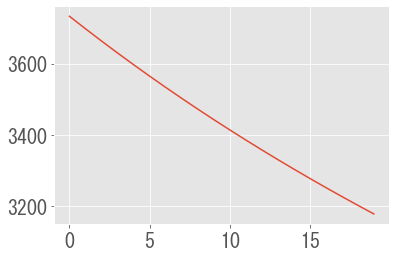

経過時間(実績)　= 0:02:46.159876 9902 / 10000 (99.01%)

score =  0.007169182358525618
lambda_p = 0.01, alpha = 0.001, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.162612 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.517471 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.346378 5000002 / 5057824 (98.86%)

[3154.235651174913]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.489177 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.269756 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.593813 5000002 / 5057824 (98.86%)

[3154.235651174913, 3130.854831249631]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.325090 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.546997 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.415931 5000002 / 5057824 (98.86%)

[3154.235651174913, 3130.854831249631, 3107.899209248957]
======= t =  3 =========
update P
経過時間(実績)　

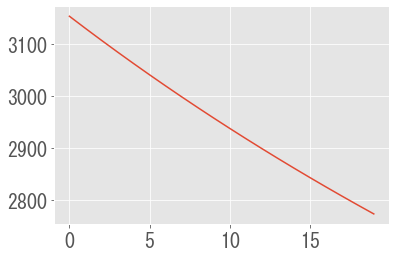

経過時間(実績)　= 0:02:48.769029 9902 / 10000 (99.01%)

score =  0.0107543921407248
lambda_p = 0.01, alpha = 0.001, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.949330 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.434988 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.595853 5000002 / 5057824 (98.86%)

[2756.5183810743906]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.731713 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.573295 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.619492 5000002 / 5057824 (98.86%)

[2756.5183810743906, 2739.936997891103]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:27.981457 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.697436 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.725839 5000002 / 5057824 (98.86%)

[2756.5183810743906, 2739.936997891103, 2723.6190149074]
======= t =  3 =========
update P
経過時間(実績)　=

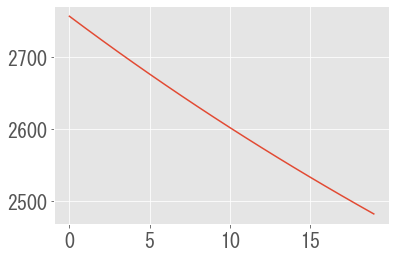

経過時間(実績)　= 0:02:44.467992 9902 / 10000 (99.01%)

score =  0.013951336693940525
lambda_p = 0.01, alpha = 0.001, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.758335 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.033035 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.666542 5000002 / 5057824 (98.86%)

[2469.2330105700034]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.568574 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.848326 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.070812 5000002 / 5057824 (98.86%)

[2469.2330105700034, 2457.0890793194817]


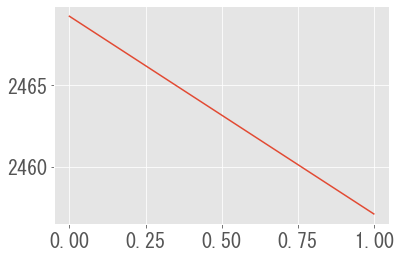

経過時間(実績)　= 0:02:44.385407 9902 / 10000 (99.01%)

score =  0.01414806125187082
lambda_p = 0.01, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.393126 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.161735 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.220206 5000002 / 5057824 (98.86%)

[2445.0736104925522]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.427432 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.518214 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.639759 5000002 / 5057824 (98.86%)

[2445.0736104925522, 2433.9647489888916]


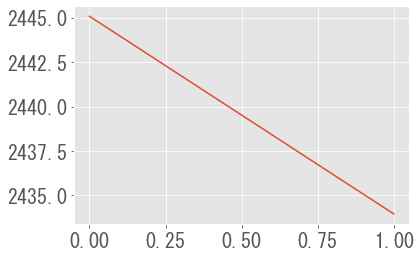

経過時間(実績)　= 0:02:44.274235 9902 / 10000 (99.01%)

score =  0.014427220107666571
lambda_p = 0.01, alpha = 0.001, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.841640 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.284098 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.881110 5000002 / 5057824 (98.86%)

[2422.7216870732605]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.557584 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.840056 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.345964 5000002 / 5057824 (98.86%)

[2422.7216870732605, 2415.7947980214303]


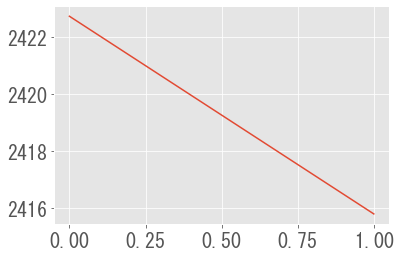

経過時間(実績)　= 0:02:44.830361 9902 / 10000 (99.01%)

score =  0.014429731498177995
lambda_p = 0.01, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.009344 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.177138 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.197068 5000002 / 5057824 (98.86%)

[2409.262988469723]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.379514 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.994939 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.200409 5000002 / 5057824 (98.86%)

[2409.262988469723, 2397.9199306200603]


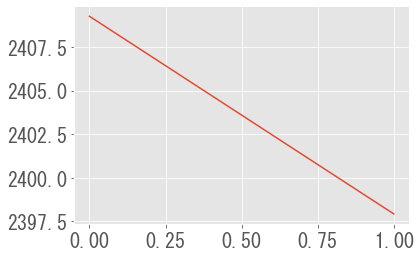

経過時間(実績)　= 0:02:45.023291 9902 / 10000 (99.01%)

score =  0.014841431489593077
lambda_p = 0.01, alpha = 0.01, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.713583 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.013630 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.792409 5000002 / 5057824 (98.86%)

[2386.7375848006204]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.568975 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.056414 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.109376 5000002 / 5057824 (98.86%)

[2386.7375848006204, 2375.7203083148397]


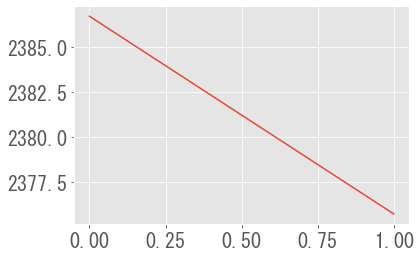

経過時間(実績)　= 0:02:44.439458 9902 / 10000 (99.01%)

score =  0.015057829913073115
lambda_p = 0.01, alpha = 0.01, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.366885 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.967876 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.847630 5000002 / 5057824 (98.86%)

[2364.8526952211587]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.790021 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.157958 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.803798 5000002 / 5057824 (98.86%)

[2364.8526952211587, 2354.2082839729724]


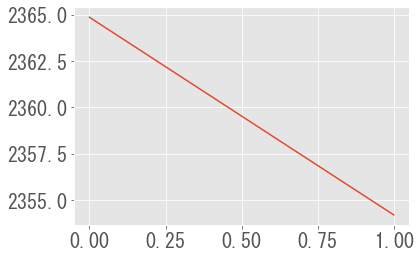

経過時間(実績)　= 0:02:44.587484 9902 / 10000 (99.01%)

score =  0.015578483623109486
lambda_p = 0.01, alpha = 0.01, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.331855 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.854688 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.437277 5000002 / 5057824 (98.86%)

[2343.6664691414335]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.868089 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.609761 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.180243 5000002 / 5057824 (98.86%)

[2343.6664691414335, 2333.9184805391687]


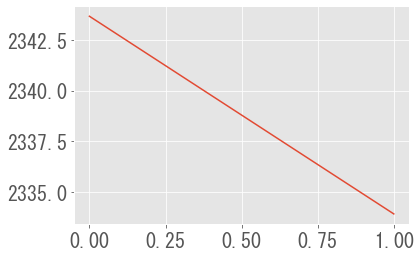

経過時間(実績)　= 0:02:44.877785 9902 / 10000 (99.01%)

score =  0.01571155357403523
lambda_p = 0.01, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.973350 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.657499 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.816441 5000002 / 5057824 (98.86%)

[2324.0224716389184]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.938135 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.102395 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.894736 5000002 / 5057824 (98.86%)

[2324.0224716389184, 2317.9372029527017]


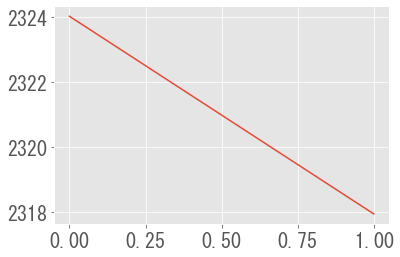

経過時間(実績)　= 0:02:45.729105 9902 / 10000 (99.01%)

score =  0.01581656288370926
lambda_p = 0.01, alpha = 0.01, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:02:05.949701 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.927561 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.396644 5000002 / 5057824 (98.86%)

[2311.4975996744433]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:18.412550 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:56.890022 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.036782 5000002 / 5057824 (98.86%)

[2311.4975996744433, 2310.0742762344753]


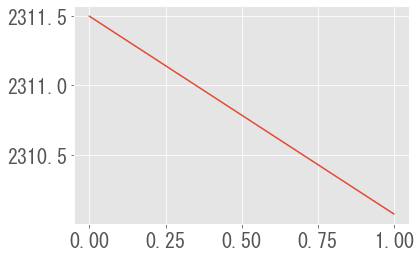

経過時間(実績)　= 0:02:25.575127 9902 / 10000 (99.01%)

score =  0.015856282724482862
lambda_p = 0.01, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:15.730722 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.296057 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.593872 5000002 / 5057824 (98.86%)

[2309.3660299740295]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:16.392956 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:53.727041 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.382179 5000002 / 5057824 (98.86%)

[2309.3660299740295, 2299.6390564285534]


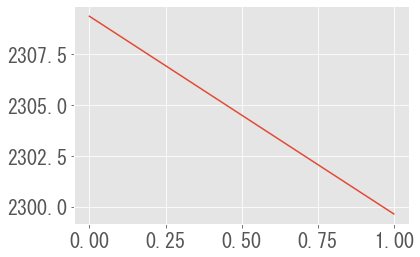

経過時間(実績)　= 0:02:23.334173 9902 / 10000 (99.01%)

score =  0.016041170595528027
lambda_p = 0.01, alpha = 0.1, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:15.191008 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.358633 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.163085 5000002 / 5057824 (98.86%)

[2290.045236364583]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:15.596578 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.138573 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.332867 5000002 / 5057824 (98.86%)

[2290.045236364583, 2280.6454459203223]


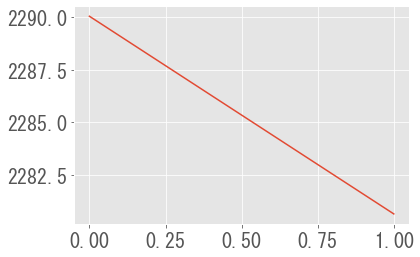

経過時間(実績)　= 0:02:25.973820 9902 / 10000 (99.01%)

score =  0.01628898834860222
lambda_p = 0.01, alpha = 0.1, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:15.654849 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:53.664743 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.270199 5000002 / 5057824 (98.86%)

[2271.3300261426452]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:16.575701 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:53.344308 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.016848 5000002 / 5057824 (98.86%)

[2271.3300261426452, 2262.7076700939206]


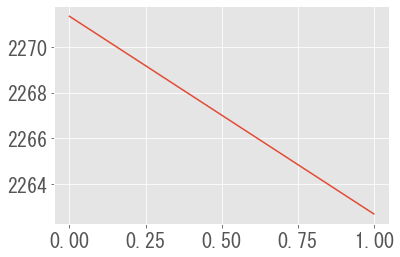

経過時間(実績)　= 0:02:21.426212 9902 / 10000 (99.01%)

score =  0.01653855338348896
lambda_p = 0.01, alpha = 0.1, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:15.131549 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:53.381311 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.427917 5000002 / 5057824 (98.86%)

[2253.935386826469]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:15.512135 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:53.518943 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.050307 5000002 / 5057824 (98.86%)

[2253.935386826469, 2248.5208992678245]


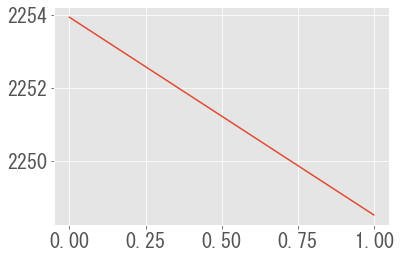

経過時間(実績)　= 0:02:20.857172 9902 / 10000 (99.01%)

score =  0.016744249496295754
lambda_p = 0.01, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:17.802889 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:56.547211 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.840280 5000002 / 5057824 (98.86%)

[2242.763369697993]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:17.239891 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.646419 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.814937 5000002 / 5057824 (98.86%)

[2242.763369697993, 2241.4875537164066]


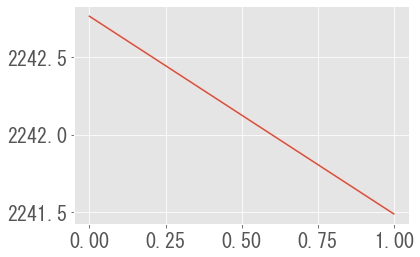

経過時間(実績)　= 0:02:23.650133 9902 / 10000 (99.01%)

score =  0.016728465914745017
lambda_p = 0.01, alpha = 0.1, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:16.259748 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.594616 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.005741 5000002 / 5057824 (98.86%)

[2240.113471486167]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:17.414187 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.131637 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.102101 5000002 / 5057824 (98.86%)

[2240.113471486167, 2239.930620950647]


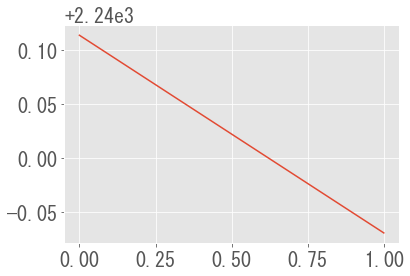

経過時間(実績)　= 0:02:23.126275 9902 / 10000 (99.01%)

score =  0.016795718822544645
lambda_p = 0.01, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:16.836692 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:55.218483 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.346534 5000002 / 5057824 (98.86%)

[2240.3699328871967]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:17.171470 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.310000 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.435570 5000002 / 5057824 (98.86%)

[2240.3699328871967, 2233.084482877139]


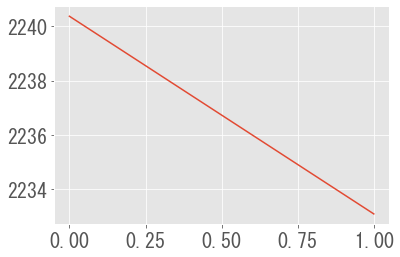

経過時間(実績)　= 0:02:23.493627 9902 / 10000 (99.01%)

score =  0.01702722526065779
lambda_p = 0.01, alpha = 1.0, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:16.233346 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.265831 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.471883 5000002 / 5057824 (98.86%)

[2225.879863025206]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:16.536711 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.499696 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.227610 5000002 / 5057824 (98.86%)

[2225.879863025206, 2219.171654048903]


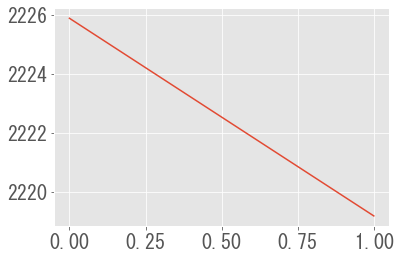

経過時間(実績)　= 0:02:24.457998 9902 / 10000 (99.01%)

score =  0.017362158028924532
lambda_p = 0.01, alpha = 1.0, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:16.175754 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.757977 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.136073 5000002 / 5057824 (98.86%)

[2212.3603318045384]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:16.728742 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.547483 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.869821 5000002 / 5057824 (98.86%)

[2212.3603318045384, 2207.969293102428]


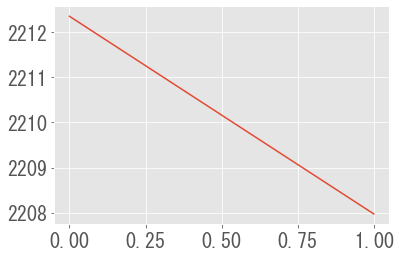

経過時間(実績)　= 0:02:24.622757 9902 / 10000 (99.01%)

score =  0.01754609888354693
lambda_p = 0.01, alpha = 1.0, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:16.070450 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:54.422851 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:21.539207 5000002 / 5057824 (98.86%)

[2203.29590615771]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:09.003796 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.631352 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.137410 5000002 / 5057824 (98.86%)

[2203.29590615771, 2202.161429990918]


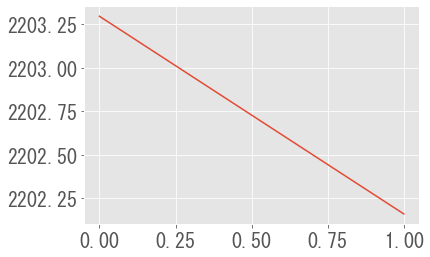

経過時間(実績)　= 0:02:50.315809 9902 / 10000 (99.01%)

score =  0.017530392239179484
lambda_p = 0.01, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.556696 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.543506 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.171095 5000002 / 5057824 (98.86%)

[2200.9347730998647]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.683708 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.597966 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.040006 5000002 / 5057824 (98.86%)

[2200.9347730998647, 2200.7680164432973]


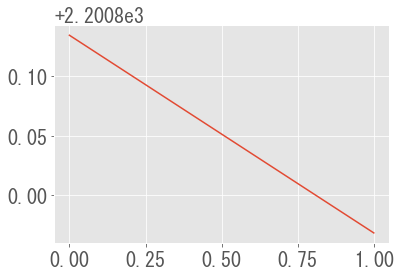

経過時間(実績)　= 0:02:49.489162 9902 / 10000 (99.01%)

score =  0.017598721229076127
lambda_p = 0.01, alpha = 1.0, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.764675 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.688312 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.986853 5000002 / 5057824 (98.86%)

[2200.5916985057743]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.703357 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.625085 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.234480 5000002 / 5057824 (98.86%)

[2200.5916985057743, 2200.5588046798634]


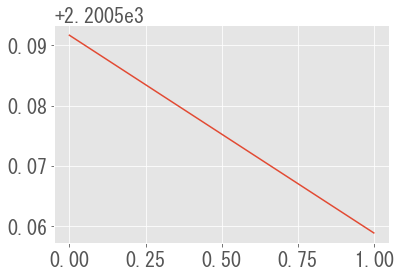

経過時間(実績)　= 0:02:46.732235 9902 / 10000 (99.01%)

score =  0.017587760843829705
lambda_p = 0.1, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.177753 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.011879 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.544005 5000002 / 5057824 (98.86%)

[22053.10251783106]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.277702 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.629011 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.555292 5000002 / 5057824 (98.86%)

[22053.10251783106, 21311.294682673393]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.444266 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.421170 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.552168 5000002 / 5057824 (98.86%)

[22053.10251783106, 21311.294682673393, 20650.192790399447]
======= t =  3 =========
update P
経過時間(実

経過時間(実績)　= 0:00:22.940186 5000002 / 5057824 (98.86%)

[22053.10251783106, 21311.294682673393, 20650.192790399447, 20058.987661645013, 19529.005834823194, 19052.945751178504, 18624.546886888023, 18238.388830068063, 17889.749445857164, 17574.497147634152, 17289.0054432841, 17030.083012305742, 16794.91526615665, 16581.015066729786, 16386.18121983453, 16208.463500307433, 16046.132789704667, 15897.655028634064, 15761.66817341986, 15636.961787169254]


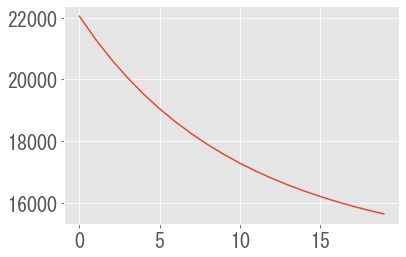

経過時間(実績)　= 0:02:44.153956 9902 / 10000 (99.01%)

score =  0.036817650287265094
lambda_p = 0.1, alpha = 0.001, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.884377 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.669167 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.474003 5000002 / 5057824 (98.86%)

[15522.457809384314]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.583847 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.418457 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.133190 5000002 / 5057824 (98.86%)

[15522.457809384314, 15417.20547169739]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:23.643301 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.819034 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.694944 5000002 / 5057824 (98.86%)

[15522.457809384314, 15417.20547169739, 15320.341038190787]
======= t =  3 =========
update P
経過時間(実

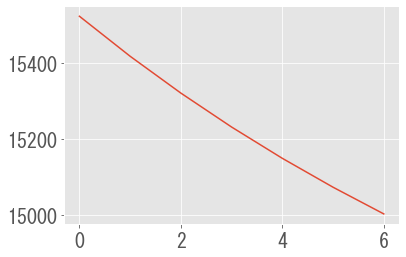

経過時間(実績)　= 0:02:43.773644 9902 / 10000 (99.01%)

score =  0.03991182486254017
lambda_p = 0.1, alpha = 0.001, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.606083 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.057521 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.859721 5000002 / 5057824 (98.86%)

[14937.667133655226]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.696144 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.356548 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.704040 5000002 / 5057824 (98.86%)

[14937.667133655226, 14877.586961748286]


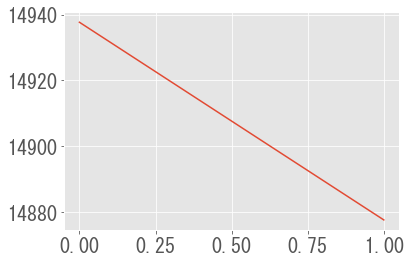

経過時間(実績)　= 0:02:44.701084 9902 / 10000 (99.01%)

score =  0.040623025066109764
lambda_p = 0.1, alpha = 0.001, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.793130 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.472162 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.162867 5000002 / 5057824 (98.86%)

[14821.829706140375]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.756251 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.766559 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.691125 5000002 / 5057824 (98.86%)

[14821.829706140375, 14770.485866722142]


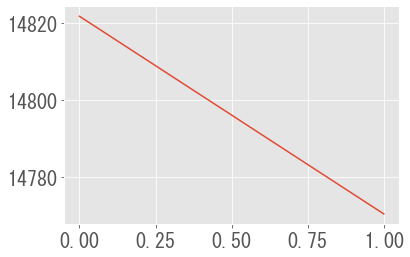

経過時間(実績)　= 0:02:44.324297 9902 / 10000 (99.01%)

score =  0.04083909911458851
lambda_p = 0.1, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.483144 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.774444 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.610766 5000002 / 5057824 (98.86%)

[14722.069485311677]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.159251 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.269477 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.999085 5000002 / 5057824 (98.86%)

[14722.069485311677, 14680.060760003793]


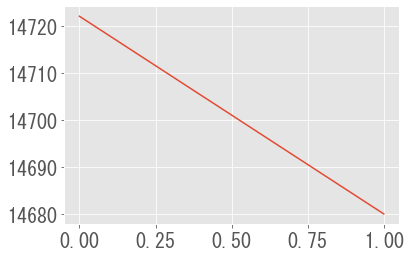

経過時間(実績)　= 0:02:44.083635 9902 / 10000 (99.01%)

score =  0.04159186507699136
lambda_p = 0.1, alpha = 0.001, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.879372 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.738637 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.219611 5000002 / 5057824 (98.86%)

[14636.76721375548]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.964507 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.582907 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.046655 5000002 / 5057824 (98.86%)

[14636.76721375548, 14611.715215814367]


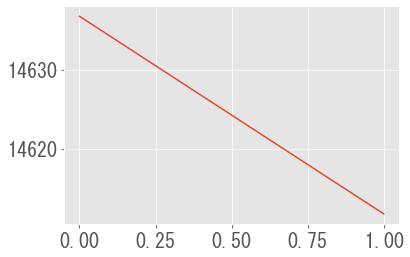

経過時間(実績)　= 0:02:45.016703 9902 / 10000 (99.01%)

score =  0.04183765761574818
lambda_p = 0.1, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.865151 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.689345 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.961667 5000002 / 5057824 (98.86%)

[14593.594580379084]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:22.728554 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.524113 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.018039 5000002 / 5057824 (98.86%)

[14593.594580379084, 14558.308256121933]


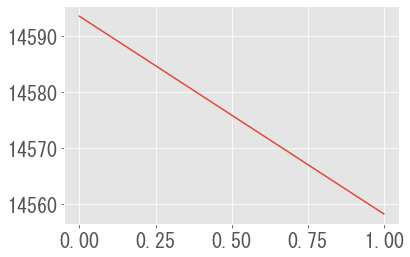

経過時間(実績)　= 0:02:45.776461 9902 / 10000 (99.01%)

score =  0.041786350199471106
lambda_p = 0.1, alpha = 0.01, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.355873 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.030166 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.096190 5000002 / 5057824 (98.86%)

[14525.275680641946]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.807705 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.451625 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.889027 5000002 / 5057824 (98.86%)

[14525.275680641946, 14494.427280250135]


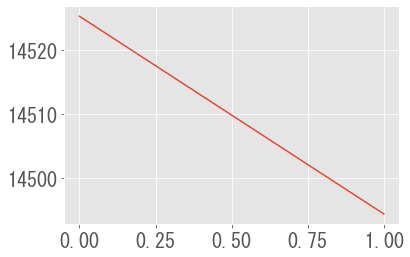

経過時間(実績)　= 0:02:45.044132 9902 / 10000 (99.01%)

score =  0.04190415437550262
lambda_p = 0.1, alpha = 0.01, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.599178 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.062822 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.860307 5000002 / 5057824 (98.86%)

[14465.547761857119]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.670331 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.497637 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.560945 5000002 / 5057824 (98.86%)

[14465.547761857119, 14438.754762779097]


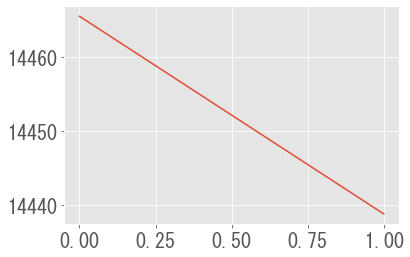

経過時間(実績)　= 0:02:45.365275 9902 / 10000 (99.01%)

score =  0.04204468063780256
lambda_p = 0.1, alpha = 0.01, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.408192 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.242019 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.072163 5000002 / 5057824 (98.86%)

[14413.235545964586]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.837256 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.961094 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.166781 5000002 / 5057824 (98.86%)

[14413.235545964586, 14390.933526685807]


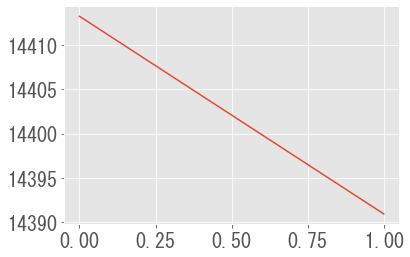

経過時間(実績)　= 0:02:44.876485 9902 / 10000 (99.01%)

score =  0.042054884742107
lambda_p = 0.1, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.295145 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.131100 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.538687 5000002 / 5057824 (98.86%)

[14367.588911217335]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.479732 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.400012 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.485514 5000002 / 5057824 (98.86%)

[14367.588911217335, 14353.514694192201]


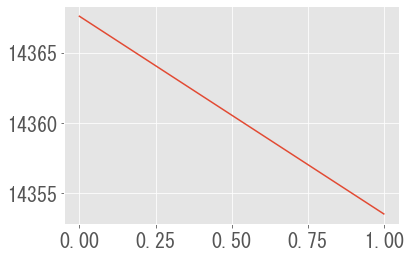

経過時間(実績)　= 0:02:44.596838 9902 / 10000 (99.01%)

score =  0.04210140836813008
lambda_p = 0.1, alpha = 0.01, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.212353 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.420960 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.726989 5000002 / 5057824 (98.86%)

[14337.43197973793]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.451395 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.039585 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.643858 5000002 / 5057824 (98.86%)

[14337.43197973793, 14332.72159615866]


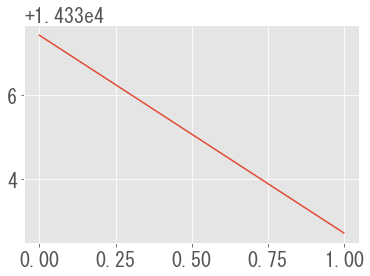

経過時間(実績)　= 0:02:46.298547 9902 / 10000 (99.01%)

score =  0.04227091564104712
lambda_p = 0.1, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.904385 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.540277 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.878453 5000002 / 5057824 (98.86%)

[14336.770338252634]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.257226 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.387955 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.569849 5000002 / 5057824 (98.86%)

[14336.770338252634, 14318.667954231973]


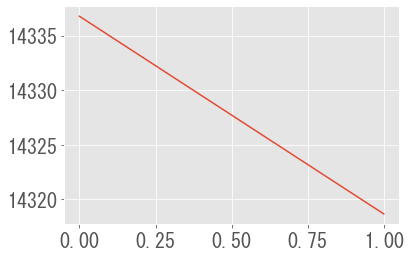

経過時間(実績)　= 0:02:44.633218 9902 / 10000 (99.01%)

score =  0.04263968318246035
lambda_p = 0.1, alpha = 0.1, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.780827 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.610779 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.193299 5000002 / 5057824 (98.86%)

[14301.553444182056]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.209978 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.073631 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.756819 5000002 / 5057824 (98.86%)

[14301.553444182056, 14285.482896169477]


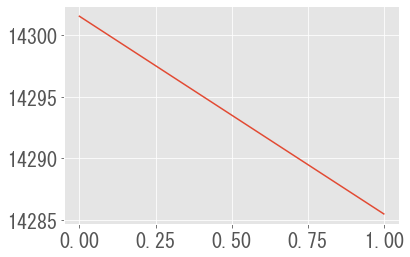

経過時間(実績)　= 0:02:44.851279 9902 / 10000 (99.01%)

score =  0.04296747947926109
lambda_p = 0.1, alpha = 0.1, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.894698 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.324354 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.832355 5000002 / 5057824 (98.86%)

[14270.079245123074]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.927279 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.382076 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.695048 5000002 / 5057824 (98.86%)

[14270.079245123074, 14256.413495899547]


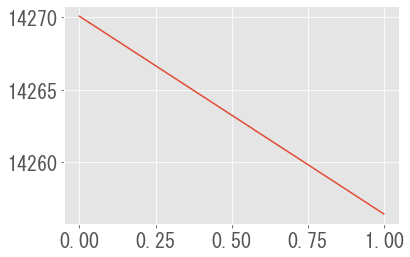

経過時間(実績)　= 0:02:45.100462 9902 / 10000 (99.01%)

score =  0.04290751970908233
lambda_p = 0.1, alpha = 0.1, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.402988 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.111758 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.225763 5000002 / 5057824 (98.86%)

[14242.463452625918]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.814129 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.410965 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.408762 5000002 / 5057824 (98.86%)

[14242.463452625918, 14233.234690174319]


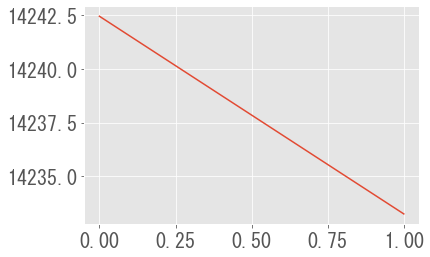

経過時間(実績)　= 0:02:45.579353 9902 / 10000 (99.01%)

score =  0.0429306463514015
lambda_p = 0.1, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.229701 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.686364 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.172096 5000002 / 5057824 (98.86%)

[14223.533803101689]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.527139 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.603735 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.415342 5000002 / 5057824 (98.86%)

[14223.533803101689, 14219.782398330877]


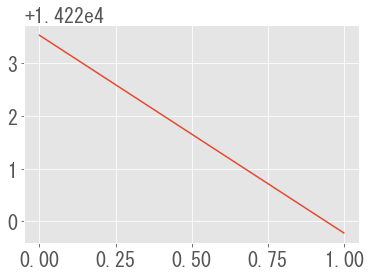

経過時間(実績)　= 0:02:46.023462 9902 / 10000 (99.01%)

score =  0.04265024292190644
lambda_p = 0.1, alpha = 0.1, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.037747 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.322102 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.389025 5000002 / 5057824 (98.86%)

[14216.593405917276]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.584526 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.059572 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.111580 5000002 / 5057824 (98.86%)

[14216.593405917276, 14215.94412176918]


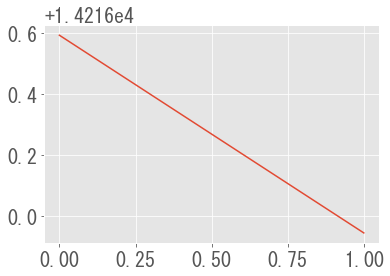

経過時間(実績)　= 0:02:45.099730 9902 / 10000 (99.01%)

score =  0.04255625781669705
lambda_p = 0.1, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.072039 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.856102 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.970323 5000002 / 5057824 (98.86%)

[14219.229809281554]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.212598 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.981943 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.287474 5000002 / 5057824 (98.86%)

[14219.229809281554, 14209.776718744188]


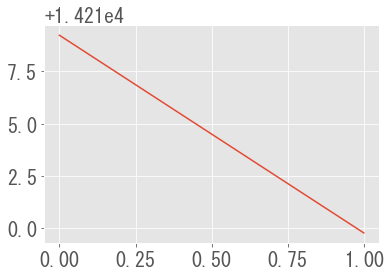

経過時間(実績)　= 0:02:47.511733 9902 / 10000 (99.01%)

score =  0.04235600496377251
lambda_p = 0.1, alpha = 1.0, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.798389 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.640420 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.515736 5000002 / 5057824 (98.86%)

[14200.809398194597]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.458995 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.351458 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.859860 5000002 / 5057824 (98.86%)

[14200.809398194597, 14192.440803290638]


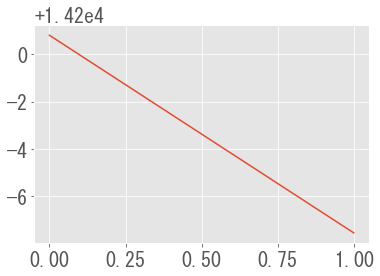

経過時間(実績)　= 0:02:44.889224 9902 / 10000 (99.01%)

score =  0.04229505261745137
lambda_p = 0.1, alpha = 1.0, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.976501 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.298733 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.441505 5000002 / 5057824 (98.86%)

[14185.028000813934]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.267049 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.791554 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.094991 5000002 / 5057824 (98.86%)

[14185.028000813934, 14178.822305783191]


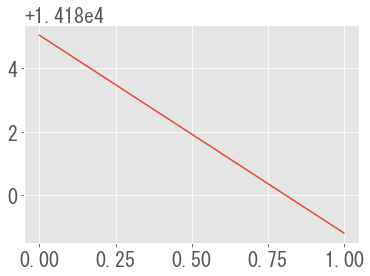

経過時間(実績)　= 0:02:45.544044 9902 / 10000 (99.01%)

score =  0.042147333801483604
lambda_p = 0.1, alpha = 1.0, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.479154 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.565003 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.478419 5000002 / 5057824 (98.86%)

[14173.427390978408]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.960469 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.782620 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.382467 5000002 / 5057824 (98.86%)

[14173.427390978408, 14170.493626077287]


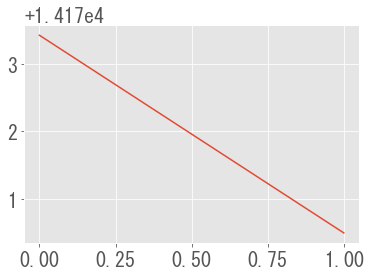

経過時間(実績)　= 0:02:49.705189 9902 / 10000 (99.01%)

score =  0.04188713509269867
lambda_p = 0.1, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.072511 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.325484 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.272514 5000002 / 5057824 (98.86%)

[14168.248127005401]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.153662 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.273757 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.013783 5000002 / 5057824 (98.86%)

[14168.248127005401, 14167.722684869354]


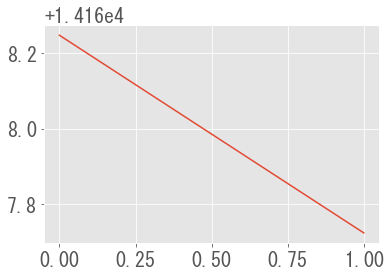

経過時間(実績)　= 0:02:48.504860 9902 / 10000 (99.01%)

score =  0.04198996965271906
lambda_p = 0.1, alpha = 1.0, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.350769 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.758097 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.300056 5000002 / 5057824 (98.86%)

[14167.247959637825]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.982936 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.795402 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.799745 5000002 / 5057824 (98.86%)

[14167.247959637825, 14167.150433476376]


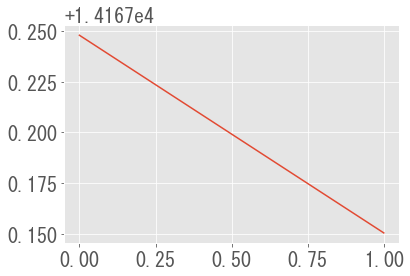

経過時間(実績)　= 0:02:47.861847 9902 / 10000 (99.01%)

score =  0.041986928016927896
lambda_p = 1.0, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.032148 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.774212 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.335834 5000002 / 5057824 (98.86%)

[141148.21890660885]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.913768 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.416940 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.913585 5000002 / 5057824 (98.86%)

[141148.21890660885, 140192.978172431]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.126059 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.581505 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.437090 5000002 / 5057824 (98.86%)

[141148.21890660885, 140192.978172431, 139710.36164922002]


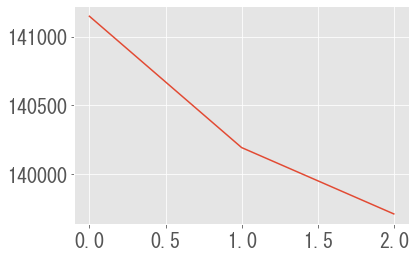

経過時間(実績)　= 0:02:46.379052 9902 / 10000 (99.01%)

score =  0.0430186478923214
lambda_p = 1.0, alpha = 0.001, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:31.124484 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.488938 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.155147 5000002 / 5057824 (98.86%)

[139376.35435888486]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.846616 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.796675 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.222161 5000002 / 5057824 (98.86%)

[139376.35435888486, 139133.2135688303]


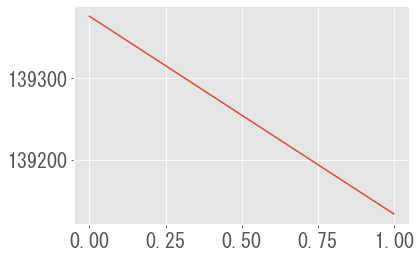

経過時間(実績)　= 0:02:47.574282 9902 / 10000 (99.01%)

score =  0.041117618901697676
lambda_p = 1.0, alpha = 0.001, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.120346 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.246541 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.189588 5000002 / 5057824 (98.86%)

[138954.65023054468]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.947983 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.693253 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.071963 5000002 / 5057824 (98.86%)

[138954.65023054468, 138817.72250415065]


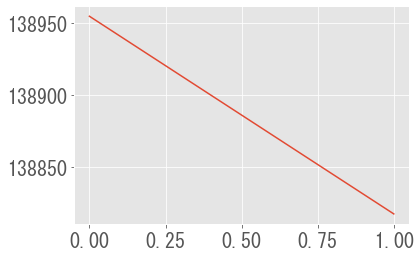

経過時間(実績)　= 0:02:47.460050 9902 / 10000 (99.01%)

score =  0.039878302420710054
lambda_p = 1.0, alpha = 0.001, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.244523 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.929667 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.647922 5000002 / 5057824 (98.86%)

[138736.97841332157]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.038708 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.973682 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.729932 5000002 / 5057824 (98.86%)

[138736.97841332157, 138653.76239968595]


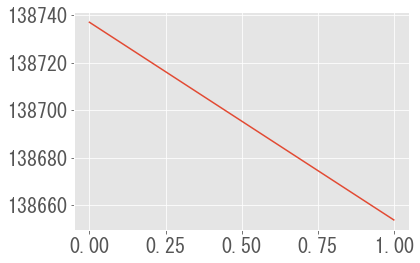

経過時間(実績)　= 0:02:48.476493 9902 / 10000 (99.01%)

score =  0.03784788768585423
lambda_p = 1.0, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.755794 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.743956 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.577316 5000002 / 5057824 (98.86%)

[138822.2706685736]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.164116 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.690683 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.097510 5000002 / 5057824 (98.86%)

[138822.2706685736, 138748.55536959224]


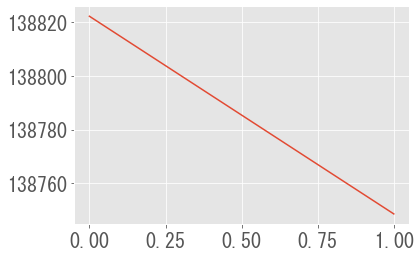

経過時間(実績)　= 0:02:47.418594 9902 / 10000 (99.01%)

score =  0.03703757049760441
lambda_p = 1.0, alpha = 0.001, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.238448 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.229694 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.122982 5000002 / 5057824 (98.86%)

[140185.53628091456]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.237372 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.184747 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.462333 5000002 / 5057824 (98.86%)

[140185.53628091456, 139788.33832302006]


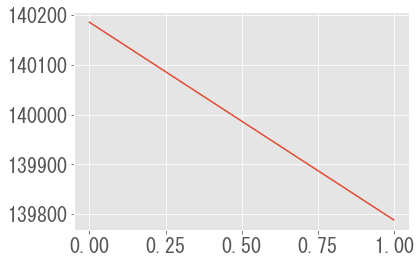

経過時間(実績)　= 0:02:48.093800 9902 / 10000 (99.01%)

score =  0.03596975754318915
lambda_p = 1.0, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.161420 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.964425 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.004071 5000002 / 5057824 (98.86%)

[138271.00785676544]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:25.275308 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.417752 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.639342 5000002 / 5057824 (98.86%)

[138271.00785676544, 138325.33072505466]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:26.505748 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.389027 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.499885 5000002 / 5057824 (98.86%)

[138271.00785676544, 138325.33072505466, 138344.67891276078]
======= t =  3 =========
update P
経過時間(

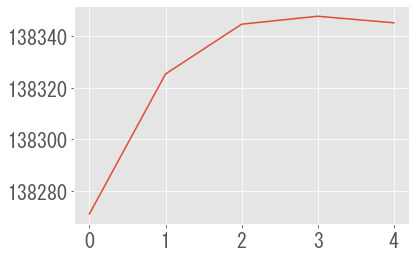

経過時間(実績)　= 0:02:51.014337 9902 / 10000 (99.01%)

score =  0.031361923030994054
lambda_p = 1.0, alpha = 0.01, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.921424 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.065302 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.340834 5000002 / 5057824 (98.86%)

[138343.39576738677]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.139879 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.699756 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.730063 5000002 / 5057824 (98.86%)

[138343.39576738677, 138338.3471437729]


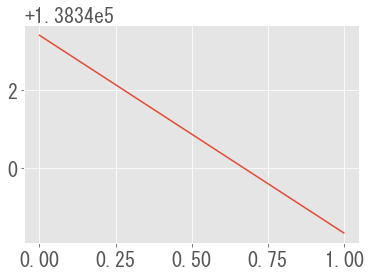

経過時間(実績)　= 0:02:48.142584 9902 / 10000 (99.01%)

score =  0.030146271567978833
lambda_p = 1.0, alpha = 0.01, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.880335 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.653469 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.245634 5000002 / 5057824 (98.86%)

[138359.60637514538]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:27.189076 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.298957 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.204083 5000002 / 5057824 (98.86%)

[138359.60637514538, 138352.78116496865]


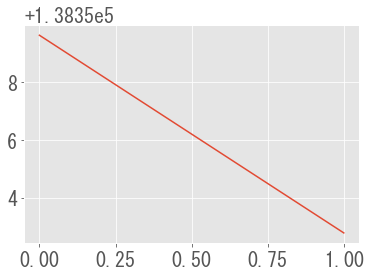

経過時間(実績)　= 0:02:47.268203 9902 / 10000 (99.01%)

score =  0.02845331662847778
lambda_p = 1.0, alpha = 0.01, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.996603 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.311967 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.009402 5000002 / 5057824 (98.86%)

[138593.1171258569]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.062765 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.240044 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.778212 5000002 / 5057824 (98.86%)

[138593.1171258569, 138562.30752809736]


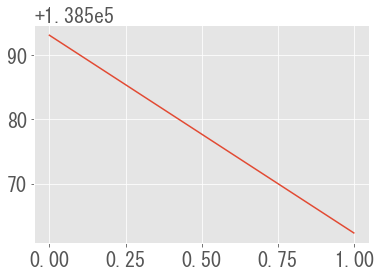

経過時間(実績)　= 0:02:48.601099 9902 / 10000 (99.01%)

score =  0.02754751997548558
lambda_p = 1.0, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:25.952581 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.791539 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.690826 5000002 / 5057824 (98.86%)

[140106.75690290448]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.969890 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.428292 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.570016 5000002 / 5057824 (98.86%)

[140106.75690290448, 139762.5932363478]


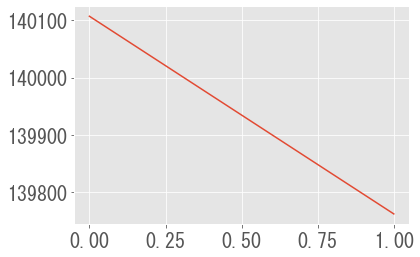

経過時間(実績)　= 0:02:46.937412 9902 / 10000 (99.01%)

score =  0.027052771397303665
lambda_p = 1.0, alpha = 0.01, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.769262 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.133417 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.885941 5000002 / 5057824 (98.86%)

[141565.47667850432]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.330672 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.255570 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.096130 5000002 / 5057824 (98.86%)

[141565.47667850432, 140470.00105453725]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.089777 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.941114 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.404687 5000002 / 5057824 (98.86%)

[141565.47667850432, 140470.00105453725, 140095.02663109172]


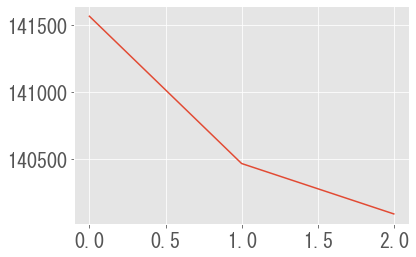

経過時間(実績)　= 0:02:46.817072 9902 / 10000 (99.01%)

score =  0.02654053665015407
lambda_p = 1.0, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.533493 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.764673 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.592053 5000002 / 5057824 (98.86%)

[138108.71009378176]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.115665 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.656193 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.801797 5000002 / 5057824 (98.86%)

[138108.71009378176, 138163.8886739774]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.056055 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.649710 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.607488 5000002 / 5057824 (98.86%)

[138108.71009378176, 138163.8886739774, 138230.84560773298]
======= t =  3 =========
update P
経過時間(実績)

経過時間(実績)　= 0:00:23.810032 5000002 / 5057824 (98.86%)

[138108.71009378176, 138163.8886739774, 138230.84560773298, 138267.81716173192, 138289.45928986906, 138303.02660451157, 138311.9926564153, 138318.15992261138, 138322.53702639125, 138325.7234020503, 138328.0925223039, 138329.88598422703, 138331.2649391374, 138332.3396766316, 138333.1873628937, 138333.8630468233, 138334.4066855422, 138334.84774029296, 138335.20824540633, 138335.50489757914]


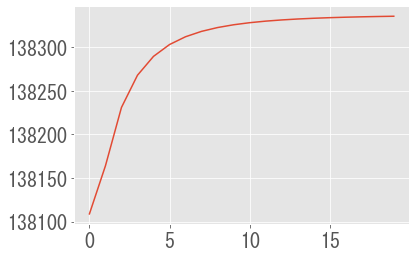

経過時間(実績)　= 0:02:52.592217 9902 / 10000 (99.01%)

score =  0.018255407316447297
lambda_p = 1.0, alpha = 0.1, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.682260 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.519175 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.999959 5000002 / 5057824 (98.86%)

[138362.39553907068]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.482110 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:09.760415 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.969219 5000002 / 5057824 (98.86%)

[138362.39553907068, 138359.91940966013]


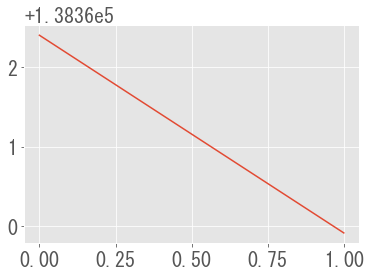

経過時間(実績)　= 0:02:54.347984 9902 / 10000 (99.01%)

score =  0.017808728812131573
lambda_p = 1.0, alpha = 0.1, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.734619 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.605563 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.830654 5000002 / 5057824 (98.86%)

[138609.03811451583]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.802906 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.273126 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.836197 5000002 / 5057824 (98.86%)

[138609.03811451583, 138581.23302370493]


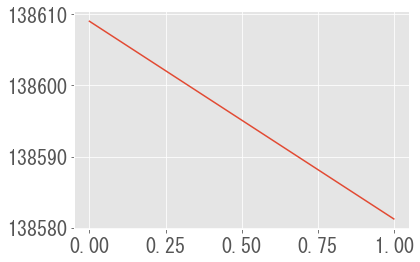

経過時間(実績)　= 0:02:53.515535 9902 / 10000 (99.01%)

score =  0.017218736406541337
lambda_p = 1.0, alpha = 0.1, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.421897 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.667415 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.066244 5000002 / 5057824 (98.86%)

[140165.9081076312]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.783652 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.639101 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.320317 5000002 / 5057824 (98.86%)

[140165.9081076312, 139873.43804950168]


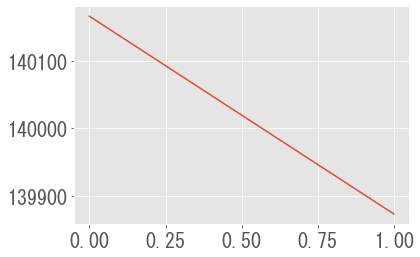

経過時間(実績)　= 0:02:53.129973 9902 / 10000 (99.01%)

score =  0.017168944199565817
lambda_p = 1.0, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.378934 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.403596 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.563113 5000002 / 5057824 (98.86%)

[142118.17392111506]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.604370 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.564013 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:27.469616 5000002 / 5057824 (98.86%)

[142118.17392111506, 140707.03596132455]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:36.483921 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.211428 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.526780 5000002 / 5057824 (98.86%)

[142118.17392111506, 140707.03596132455, 140248.97101210302]


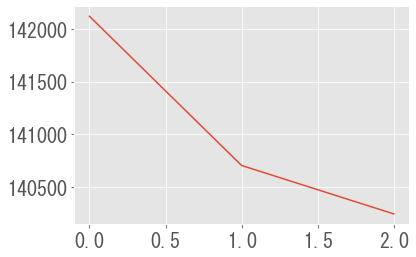

経過時間(実績)　= 0:03:05.138804 9902 / 10000 (99.01%)

score =  0.018040410172633112
lambda_p = 1.0, alpha = 0.1, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:34.940060 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.120687 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.176165 5000002 / 5057824 (98.86%)

[140733.5850634689]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:35.939224 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:14.458244 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.114396 5000002 / 5057824 (98.86%)

[140733.5850634689, 140337.12926414568]


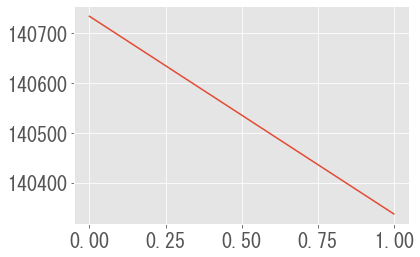

経過時間(実績)　= 0:03:04.597588 9902 / 10000 (99.01%)

score =  0.018596509858079948
lambda_p = 1.0, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:35.129010 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.621152 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.409857 5000002 / 5057824 (98.86%)

[138283.7366782731]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:34.386940 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.361259 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.136737 5000002 / 5057824 (98.86%)

[138283.7366782731, 138317.54073468814]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:34.813909 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:13.725643 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:26.261730 5000002 / 5057824 (98.86%)

[138283.7366782731, 138317.54073468814, 138380.4849736463]
======= t =  3 =========
update P
経過時間(実績)　

経過時間(実績)　= 0:00:24.505872 5000002 / 5057824 (98.86%)

[138283.7366782731, 138317.54073468814, 138380.4849736463, 138416.7537593831, 138438.78752672832, 138453.74991557247, 138464.5954913198, 138472.70719049888, 138478.93372773367, 138483.83040736947, 138487.76597904612, 138490.98799384458, 138493.66535802357, 138495.91636889323, 138497.8265549267, 138499.4596344903, 138500.8642948937, 138502.07853142725, 138503.13252662963, 138504.05062106616]


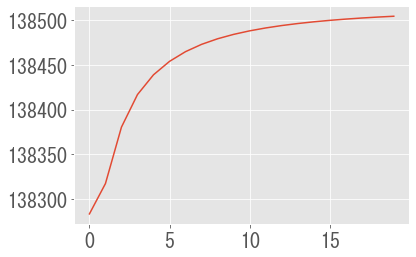

経過時間(実績)　= 0:02:52.697874 9902 / 10000 (99.01%)

score =  0.014312625613402642
lambda_p = 1.0, alpha = 1.0, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.907741 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.261262 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.692012 5000002 / 5057824 (98.86%)

[138761.01265563167]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.122665 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.058916 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.119459 5000002 / 5057824 (98.86%)

[138761.01265563167, 138735.7330727728]


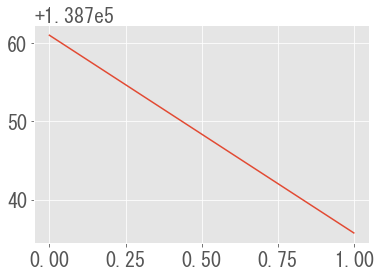

経過時間(実績)　= 0:02:53.666778 9902 / 10000 (99.01%)

score =  0.014091966416216488
lambda_p = 1.0, alpha = 1.0, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.997613 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.107010 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.409812 5000002 / 5057824 (98.86%)

[140333.426753076]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.158486 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.346587 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.782049 5000002 / 5057824 (98.86%)

[140333.426753076, 140073.13159285815]


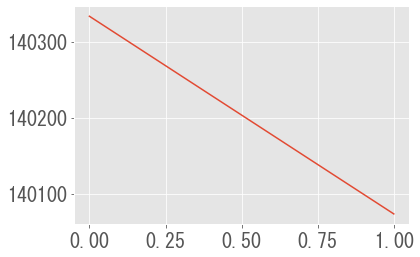

経過時間(実績)　= 0:02:53.313510 9902 / 10000 (99.01%)

score =  0.015104961859984953
lambda_p = 1.0, alpha = 1.0, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.225745 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.185581 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.404666 5000002 / 5057824 (98.86%)

[142094.48896436312]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.151113 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.235671 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.822956 5000002 / 5057824 (98.86%)

[142094.48896436312, 140809.187101838]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:28.681477 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.162564 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.022547 5000002 / 5057824 (98.86%)

[142094.48896436312, 140809.187101838, 140419.43453972606]


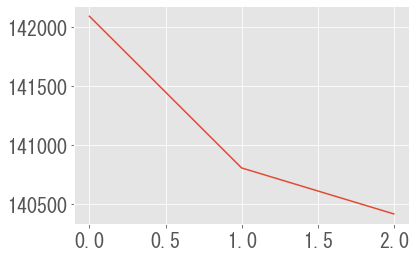

経過時間(実績)　= 0:02:52.730383 9902 / 10000 (99.01%)

score =  0.01664347135098536
lambda_p = 1.0, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:27.711069 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.976177 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.181249 5000002 / 5057824 (98.86%)

[140948.021863555]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.211845 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.429373 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.567300 5000002 / 5057824 (98.86%)

[140948.021863555, 140524.27504605788]


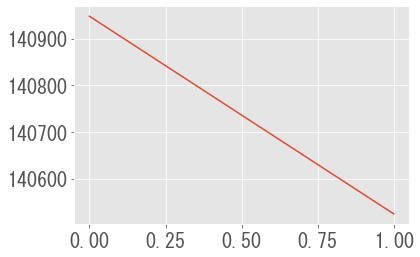

経過時間(実績)　= 0:02:51.900829 9902 / 10000 (99.01%)

score =  0.01926282073814602
lambda_p = 1.0, alpha = 1.0, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.455918 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.078672 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.341042 5000002 / 5057824 (98.86%)

[140457.20544759327]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.778543 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.299601 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.187284 5000002 / 5057824 (98.86%)

[140457.20544759327, 140423.43503676233]


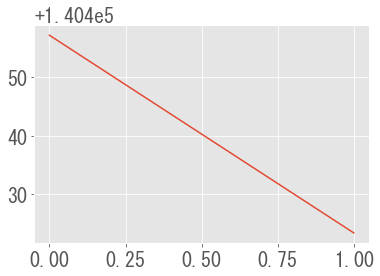

経過時間(実績)　= 0:02:52.166377 9902 / 10000 (99.01%)

score =  0.019199024607611213
lambda_p = 10.0, alpha = 0.001, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.663742 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.046791 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.623477 5000002 / 5057824 (98.86%)

[1245053.8322353298]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.258356 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.825093 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.100621 5000002 / 5057824 (98.86%)

[1245053.8322353298, 1228543.8976177305]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:29.586573 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.926299 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.552928 5000002 / 5057824 (98.86%)

[1245053.8322353298, 1228543.8976177305, 1226075.5371987792]


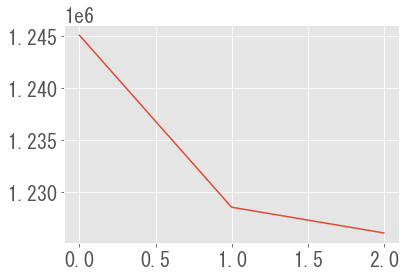

経過時間(実績)　= 0:02:52.348788 9902 / 10000 (99.01%)

score =  0.012062893183763494
lambda_p = 10.0, alpha = 0.001, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.271950 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.150888 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.075056 5000002 / 5057824 (98.86%)

[1225276.4514465758]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.554655 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.856993 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.500278 5000002 / 5057824 (98.86%)

[1225276.4514465758, 1224975.4897582165]


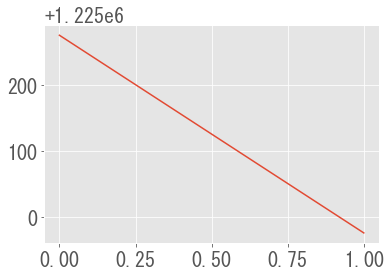

経過時間(実績)　= 0:02:55.094289 9902 / 10000 (99.01%)

score =  0.011312252707302984
lambda_p = 10.0, alpha = 0.001, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.544887 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.864304 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.953177 5000002 / 5057824 (98.86%)

[1224951.312499419]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.489453 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.007132 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.513173 5000002 / 5057824 (98.86%)

[1224951.312499419, 1224909.6209135416]


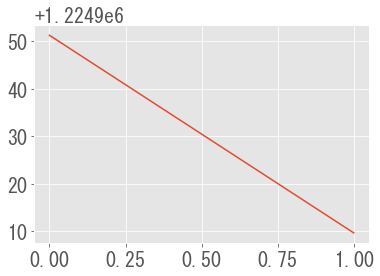

経過時間(実績)　= 0:02:53.987749 9902 / 10000 (99.01%)

score =  0.01065863088287828
lambda_p = 10.0, alpha = 0.001, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.836663 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.330856 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.227415 5000002 / 5057824 (98.86%)

[1225787.0726661955]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.078841 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.094376 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.708372 5000002 / 5057824 (98.86%)

[1225787.0726661955, 1225745.4894430265]


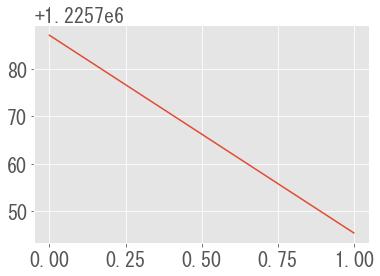

経過時間(実績)　= 0:02:53.465375 9902 / 10000 (99.01%)

score =  0.009795603688529924
lambda_p = 10.0, alpha = 0.001, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.976565 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.264770 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.660487 5000002 / 5057824 (98.86%)

[1234149.2117424349]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.644952 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.483674 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.410370 5000002 / 5057824 (98.86%)

[1234149.2117424349, 1233675.3573139592]


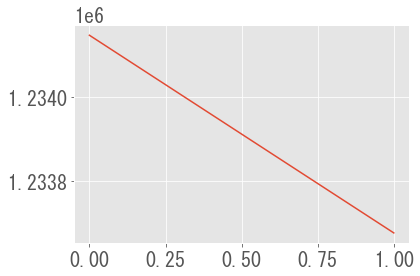

経過時間(実績)　= 0:02:51.174569 9902 / 10000 (99.01%)

score =  0.009587230550467035
lambda_p = 10.0, alpha = 0.001, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.859334 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.564803 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.911085 5000002 / 5057824 (98.86%)

[1290828.6126711904]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.122887 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.869974 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.086961 5000002 / 5057824 (98.86%)

[1290828.6126711904, 1284555.1197299892]


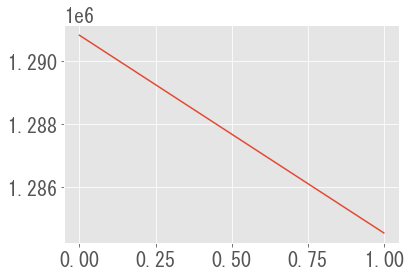

経過時間(実績)　= 0:02:51.805737 9902 / 10000 (99.01%)

score =  0.009722004368471218
lambda_p = 10.0, alpha = 0.01, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.865539 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.094745 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.915693 5000002 / 5057824 (98.86%)

[1224700.8097923582]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.345113 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.909929 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.166865 5000002 / 5057824 (98.86%)

[1224700.8097923582, 1225349.8772689768]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:29.466633 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.871443 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.637654 5000002 / 5057824 (98.86%)

[1224700.8097923582, 1225349.8772689768, 1225175.3126059691]


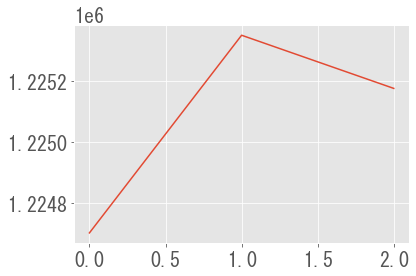

経過時間(実績)　= 0:02:52.875780 9902 / 10000 (99.01%)

score =  0.008054533889812357
lambda_p = 10.0, alpha = 0.01, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.317519 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.926954 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.164372 5000002 / 5057824 (98.86%)

[1225183.943811232]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.447725 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.737307 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.055305 5000002 / 5057824 (98.86%)

[1225183.943811232, 1225163.5002089192]


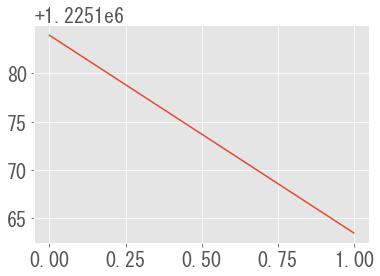

経過時間(実績)　= 0:03:06.182656 9902 / 10000 (99.01%)

score =  0.007499922356507224
lambda_p = 10.0, alpha = 0.01, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.454383 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:04.166228 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.122834 5000002 / 5057824 (98.86%)

[1226054.7964479595]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.555545 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.780179 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.216419 5000002 / 5057824 (98.86%)

[1226054.7964479595, 1226024.0528929955]


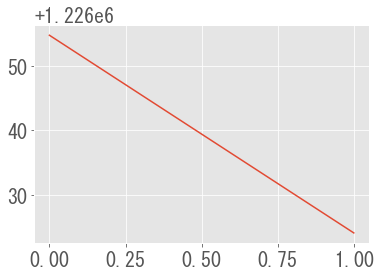

経過時間(実績)　= 0:02:51.810641 9902 / 10000 (99.01%)

score =  0.007223545254015066
lambda_p = 10.0, alpha = 0.01, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.590878 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.884461 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.880814 5000002 / 5057824 (98.86%)

[1234422.861765725]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:29.992679 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.860008 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.715252 5000002 / 5057824 (98.86%)

[1234422.861765725, 1233955.799010638]


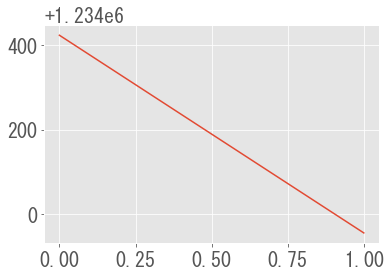

経過時間(実績)　= 0:02:52.862654 9902 / 10000 (99.01%)

score =  0.007073185505215015
lambda_p = 10.0, alpha = 0.01, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.495627 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.057081 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.072212 5000002 / 5057824 (98.86%)

[1291160.1124714247]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.058419 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.845450 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.297628 5000002 / 5057824 (98.86%)

[1291160.1124714247, 1284932.1298232141]


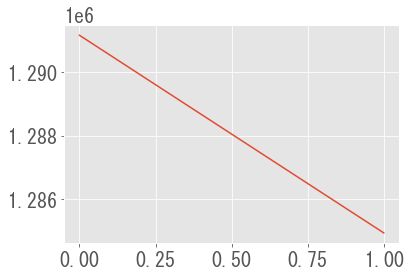

経過時間(実績)　= 0:02:54.030685 9902 / 10000 (99.01%)

score =  0.00797205263576752
lambda_p = 10.0, alpha = 0.01, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.224557 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.760346 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.845969 5000002 / 5057824 (98.86%)

[1452001.0059708513]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.033165 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.244978 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.342035 5000002 / 5057824 (98.86%)

[1452001.0059708513, 1401566.6086212024]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:29.438178 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.843139 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.413073 5000002 / 5057824 (98.86%)

[1452001.0059708513, 1401566.6086212024, 1388616.3206603946]
======= t =  3 =========
update P
経過

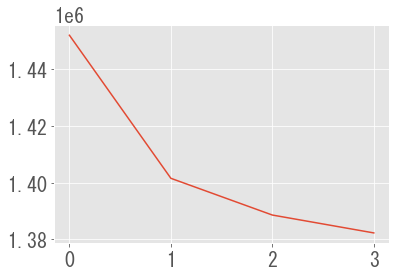

経過時間(実績)　= 0:02:51.108527 9902 / 10000 (99.01%)

score =  0.012243560690565154
lambda_p = 10.0, alpha = 0.1, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.406690 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.696691 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.996231 5000002 / 5057824 (98.86%)

[1235187.1863576714]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.116439 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.247038 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.731204 5000002 / 5057824 (98.86%)

[1235187.1863576714, 1229569.3223111168]


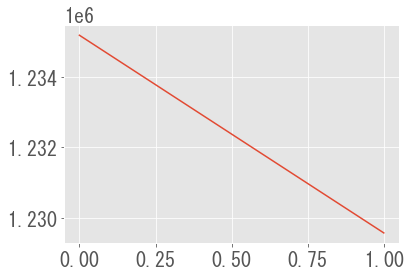

経過時間(実績)　= 0:02:52.105447 9902 / 10000 (99.01%)

score =  0.009103246259838313
lambda_p = 10.0, alpha = 0.1, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.446231 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.066001 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.079144 5000002 / 5057824 (98.86%)

[1229413.4281488997]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.249619 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:08.480375 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.687420 5000002 / 5057824 (98.86%)

[1229413.4281488997, 1229041.9179843136]


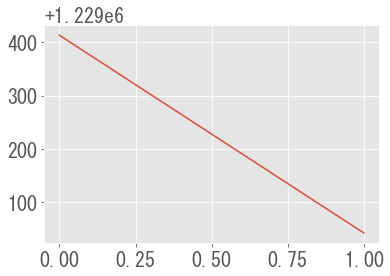

経過時間(実績)　= 0:02:52.670571 9902 / 10000 (99.01%)

score =  0.008176880097806776
lambda_p = 10.0, alpha = 0.1, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.025018 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:06.999067 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:25.133009 5000002 / 5057824 (98.86%)

[1236969.9489676985]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:28.948458 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.205372 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.622608 5000002 / 5057824 (98.86%)

[1236969.9489676985, 1236526.2351111062]


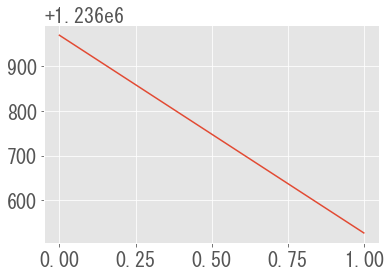

経過時間(実績)　= 0:02:53.928447 9902 / 10000 (99.01%)

score =  0.007533408319242565
lambda_p = 10.0, alpha = 0.1, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.610951 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.383171 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.957963 5000002 / 5057824 (98.86%)

[1291769.9989534449]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:30.424529 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:05.953803 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.536440 5000002 / 5057824 (98.86%)

[1291769.9989534449, 1285947.9124577397]


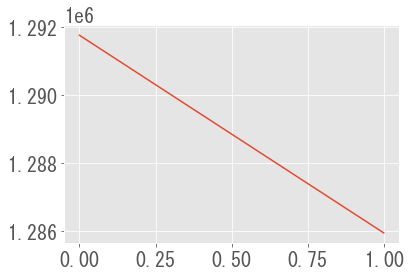

経過時間(実績)　= 0:02:49.959347 9902 / 10000 (99.01%)

score =  0.008785090780988875
lambda_p = 10.0, alpha = 0.1, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:29.194224 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:07.496660 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.853512 5000002 / 5057824 (98.86%)

[1447958.7002119238]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:17.909004 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:00.124023 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.567806 5000002 / 5057824 (98.86%)

[1447958.7002119238, 1399381.6966449413]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:18.050478 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:00.222715 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.543451 5000002 / 5057824 (98.86%)

[1447958.7002119238, 1399381.6966449413, 1386790.0369693458]
======= t =  3 =========
update P
経過時

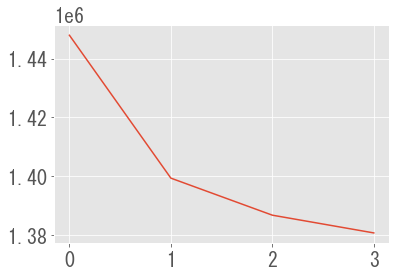

経過時間(実績)　= 0:03:22.396037 9902 / 10000 (99.01%)

score =  0.01240030675646459
lambda_p = 10.0, alpha = 0.1, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:28.027451 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.292178 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.687544 5000002 / 5057824 (98.86%)

[1481217.4419165498]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:21.119091 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:57.581408 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.513075 5000002 / 5057824 (98.86%)

[1481217.4419165498, 1429657.7784582623]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:20.486242 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.183753 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.899186 5000002 / 5057824 (98.86%)

[1481217.4419165498, 1429657.7784582623, 1412219.8462718958]
======= t =  3 =========
update P
経過時

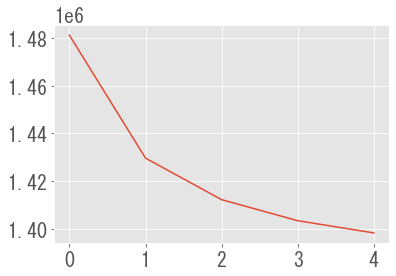

経過時間(実績)　= 0:02:28.258629 9902 / 10000 (99.01%)

score =  0.01703548851399699
lambda_p = 10.0, alpha = 1.0, r_purchase = 0.01
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:20.055354 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:58.031095 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.701563 5000002 / 5057824 (98.86%)

[1259679.4455526615]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:20.241908 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:57.689133 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.407420 5000002 / 5057824 (98.86%)

[1259679.4455526615, 1250185.6079003594]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:25.667708 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:57.999869 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.577629 5000002 / 5057824 (98.86%)

[1259679.4455526615, 1250185.6079003594, 1249319.1748785032]


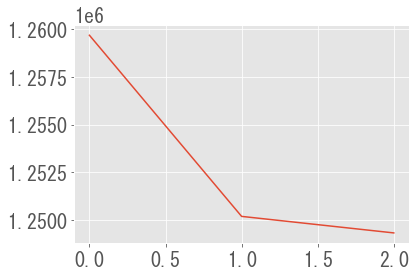

経過時間(実績)　= 0:02:34.163193 9902 / 10000 (99.01%)

score =  0.013318372718882723
lambda_p = 10.0, alpha = 1.0, r_purchase = 0.1
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:26.394974 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:03.728709 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.904251 5000002 / 5057824 (98.86%)

[1255577.2697316804]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.921700 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:02.106085 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.009635 5000002 / 5057824 (98.86%)

[1255577.2697316804, 1255343.0784640538]


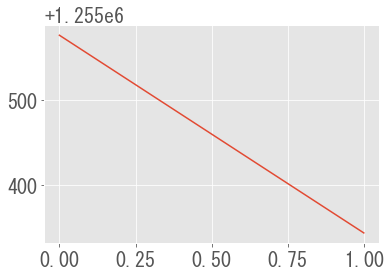

経過時間(実績)　= 0:02:37.231893 9902 / 10000 (99.01%)

score =  0.010362448681340045
lambda_p = 10.0, alpha = 1.0, r_purchase = 1.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:22.284839 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.757049 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.801754 5000002 / 5057824 (98.86%)

[1301205.1317842195]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:21.633578 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.348596 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.923913 5000002 / 5057824 (98.86%)

[1301205.1317842195, 1296836.673289775]


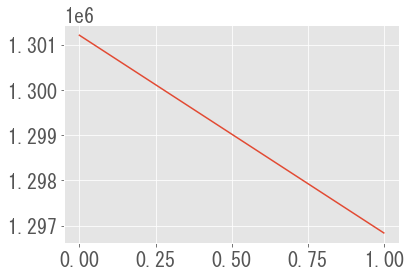

経過時間(実績)　= 0:02:32.773511 9902 / 10000 (99.01%)

score =  0.010518273886200784
lambda_p = 10.0, alpha = 1.0, r_purchase = 10.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:21.203822 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.366071 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.077447 5000002 / 5057824 (98.86%)

[1441297.035790568]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:23.130199 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.664952 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:22.912159 5000002 / 5057824 (98.86%)

[1441297.035790568, 1397489.253165972]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:21.246768 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:00:59.575529 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.032076 5000002 / 5057824 (98.86%)

[1441297.035790568, 1397489.253165972, 1386346.0806259424]
======= t =  3 =========
update P
経過時間(実績)　

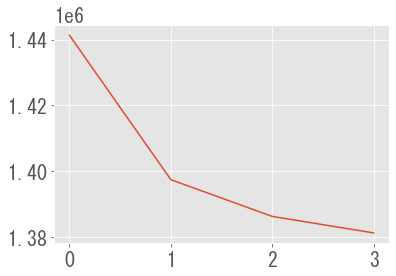

経過時間(実績)　= 0:02:37.984659 9902 / 10000 (99.01%)

score =  0.01713292273259257
lambda_p = 10.0, alpha = 1.0, r_purchase = 100.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:23.809183 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.445548 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.232867 5000002 / 5057824 (98.86%)

[1461084.5308260664]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:26.080957 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.542743 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.137994 5000002 / 5057824 (98.86%)

[1461084.5308260664, 1420555.2989411135]
======= t =  2 =========
update P
経過時間(実績)　= 0:01:24.922889 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.071200 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:24.167971 5000002 / 5057824 (98.86%)

[1461084.5308260664, 1420555.2989411135, 1407272.050256743]
======= t =  3 =========
update P
経過時間(

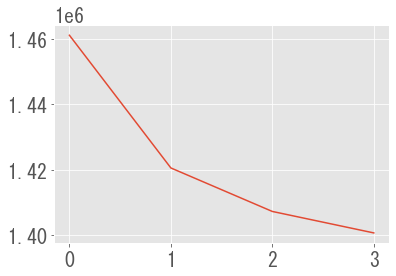

経過時間(実績)　= 0:02:36.617901 9902 / 10000 (99.01%)

score =  0.021951760196777765
lambda_p = 10.0, alpha = 1.0, r_purchase = 1000.0
処理開始：eval関係
処理0完了：np -> eval
処理1完了：session -> eval
処理2完了：item -> eval
======= t =  0 =========
update P
経過時間(実績)　= 0:01:24.381504 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.108813 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.660667 5000002 / 5057824 (98.86%)

[1412993.4045347637]
======= t =  1 =========
update P
経過時間(実績)　= 0:01:24.757937 980002 / 990000 (98.99%)

update Q
経過時間(実績)　= 0:01:01.249157 23002 / 23592 (97.49%)

calculate loss
経過時間(実績)　= 0:00:23.224915 5000002 / 5057824 (98.86%)

[1412993.4045347637, 1409262.757502104]


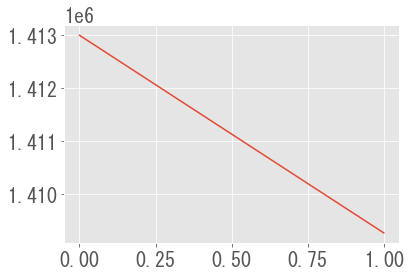

経過時間(実績)　= 0:02:37.937501 9902 / 10000 (99.01%)

score =  0.021675320801678447


In [43]:
num_iteration = 20
threshold_break = 0.005 # lossの改善が0.5%以下になったらbreak
k_dim = 100

model = matrix_factorization(df_R_train, df_item_features, k_dim, alpha = alpha_start, r_purchase = r_purchase_start, \
                             lambda_p = lambda_p_start, lambda_q = lambda_p_start)

# path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
# model.df_P = pd.read_pickle(path_data_temp + r'\df_P_IMF_k' + str(k_dim) + r'.pkl')
# model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_IMF_k' + str(k_dim) + r'.pkl')
# model.df_P = df_P_rec
# model.df_Q = df_Q_rec
model.update(50, threshold_break)

score_list_list = []

df_score = pd.DataFrame(columns = ["lambda_p", "alpha", "r_purchase", "score"])
idx_param = 0

for lambda_p in lambda_p_list:
    for alpha in alpha_list:
        for r_purchase in r_purchase_list:
            print("lambda_p = {:0}, alpha = {:1}, r_purchase = {:2}".format(lambda_p, alpha, r_purchase))
            model.reset_params(alpha, r_purchase, lambda_p = lambda_p, lambda_q = lambda_p)

            loss_list = model.update(num_iteration, threshold_break)
            if len(loss_list) > 1:
                plt.plot(range(len(loss_list)), loss_list)
                plt.show()

            # スコアの算出
            df_y_pred = model.predict_items(df_X_valid, df_candidate_items)
            score = mean_reciprocal_rank(df_y_valid, df_y_pred)
            
            df_score.loc[idx_param] = [lambda_p, alpha, r_purchase, score]
            print("score = ", score)
            idx_param += 1

各ハイパーパラメータについて，スコアをざっくり確認する．

0.01
0.1
1.0
10.0


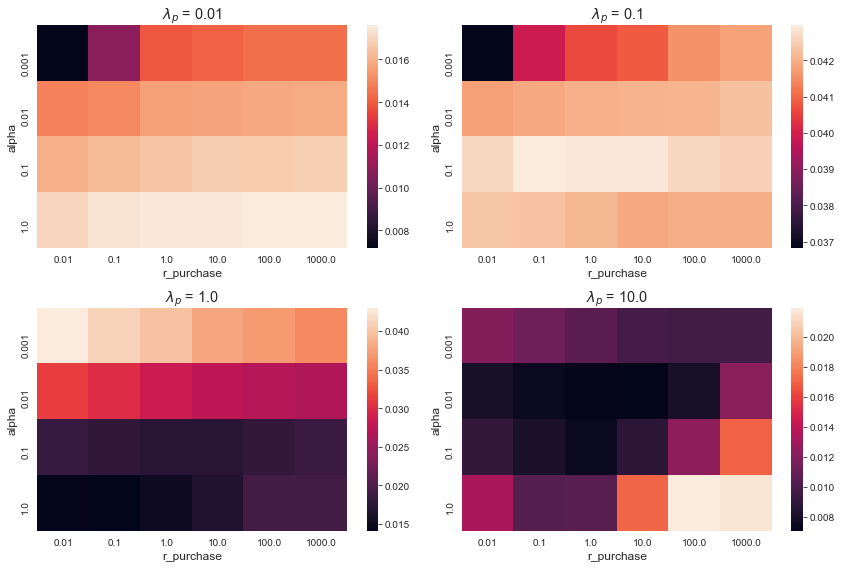

In [56]:
fig = plt.figure(figsize = (12, 8))


for idx, lambda_p in enumerate(df_score["lambda_p"].unique()):
    plt.subplot(2, 2, idx + 1)
    print(lambda_p)
    plt.title("$\lambda_p$ = {:}".format(lambda_p))
    sns.heatmap(df_score[df_score["lambda_p"] == lambda_p].pivot(index = "alpha", columns = "r_purchase", values = "score"), )
plt.tight_layout()
plt.show()
    

数値をより細かくしてグリッドサーチ

In [ ]:
alpha_start = 0.001
alpha_end = 1.0
alpha_num = 4
alpha_list = np.geomspace(alpha_start, alpha_end, alpha_num)

r_purchase_start = 0.01
r_purchase_end = 100.0
r_purchase_num = 6
r_purchase_list = np.geomspace(r_purchase_start, r_purchase_end, r_purchase_num)

lambda_p_start = 0.05
lambda_p_end = 1.0
lambda_p_num = 4
lambda_p_list = np.geomspace(lambda_p_start, lambda_p_end, lambda_p_num)
print(alpha_list)
print(r_purchase_list)
print(lambda_p_list)

In [57]:
df_score.to_excel("df_score.xlsx")